In [1]:
## Import libraries for calculation functions

import logging
import inspect
import math
import pandas as pd
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from glob import glob
from pathlib import Path
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import gamma
from scipy.interpolate import interp1d

In [2]:
## Settings and global variables for calculation functions

# This is to get the version number of the calc_funcs script being used so that it
# can be appended to the file name of any outputs. The reason this is done is because
# the calculation functions below and the plot functions in the plot_funcs script both
# output intermediate files one at a time from low level to high level, and that each
# file name is used in recognising whether there is a need to re-run a script (if the
# file already exists then the script is not run so as to save on computation).
# However, this method can propagate errors from low level through to high level
# if there has been a change to the code and/or output at the lower levels. By
# appending the version number of the calc_funcs script being used, it forces all
# intermediate files to be recreated from scratch rather than reuse intermediate files
# which was outputted by outdated code. "v00" is used as a placeholder version number
# if there is an error: it is used mostly for scripting purposes within an
# interactive python notebook where the file name cannot be directly extracted
# using the __file__ python variable.
try:
    calc_funcs_ver = "cf" + Path(__file__).stem[-3:]
except:
    calc_funcs_ver = "cfv00"

# Set level of logging out of (in decreasing order of detail): 
# [logging.DEBUG, logging.INFO, logging.WARNING, logging.ERROR, logging.CRITICAL]
calc_log_level = logging.DEBUG
log_levels = [logging.DEBUG, logging.INFO, logging.WARNING, 
              logging.ERROR, logging.CRITICAL]
assert calc_log_level in log_levels, \
    f"calc_log_level (global variable in settings section) must be one of: {log_levels}"

# Set priority of code to one of: ["speed", "memory"]. "speed" sacrifices additional 
# memory for faster processing while "memory" sacrifices faster processing for lower 
# RAM consumption. 
priority = "speed"
priorities = ["speed", "memory"]
assert priority in priorities, \
    f"priority (global variable in settings section) must be one of: {priorities}"

# Valid regions and their mapping to axis extents in [W, E, S, N] format 
# as well as timezones in hour +- GMT
regions = {
    # Central America (mostly Honduras-Nicaragua-Costa Rica)
    "ca": {"extent": [-91, -81, 7, 17], "tz": -6},
    # South America (mostly central and eastern Brazil)
    "sa": {"extent": [-65, -30, -15, 0], "tz": -3},
    # Western Australia (mostly near the west coast)
    "wa": {"extent": [113, 123, -35, -30], "tz": +8}
}

# Earliest and latest entries in each GLASS dataset
avhrr_earliest = "Jan-1981"
modis_earliest = "Mar-2000"
avhrr_latest = "Dec-2018"
modis_latest = "Dec-2021"
fapar_earliest = "Jan-1982"
fapar_latest = "Dec-2020"

assert (datetime.strptime(fapar_earliest, "%b-%Y") > 
        datetime.strptime(avhrr_earliest, "%b-%Y")), \
    "fapar_earliest must be later than avhrr_earliest since this was a design assumption"
assert (datetime.strptime(fapar_latest, "%b-%Y") < 
        datetime.strptime(modis_latest, "%b-%Y")), \
    "fapar_latest must be earlier than modis_latest since this was a design assumption"

avhrr_earliest_year = int(avhrr_earliest[-4:])
avhrr_latest_year = int(avhrr_latest[-4:])
modis_earliest_year = int(modis_earliest[-4:])
modis_latest_year = int(modis_latest[-4:])
fapar_earliest_year = int(fapar_earliest[-4:])
fapar_latest_year = int(fapar_latest[-4:])

# Size of chunks
chunksize = "500MB"

# Valid subset strings to use as argument in climatologies and
# their mapping to month numbers for use in xarray time slicing
months_subsets = {
    "all": list(range(1, 13)),
    "djf": [12,1,2], "mam": [3,4,5], "jja": [6,7,8], "son": [9,10,11]
}

# Valid variables for use in analysis
hours_all = list(range(0, 24))
vars_glass = ["lai", "fapar"]
vars_era5 = {
    "vars": {
        "sfc": ["wv10", "wv100", "mslp", "t2", "slhf", "sshf"],
        "atm": ["viec", "vipile", "vike", "tcclw", "tcwv", "nac"]
    },
    "dvars": {
        "sfc": ["dwv10", "dwv100", "dmslp", "dt2", "dslhf", "dsshf"],
        "atm": ["dviec", "dvipile", "dvike", "dtcclw", "dtcwv", "dnac"]
    }
}
vars_and_dvars_era5_all = []
for var_type, var_dict in vars_era5.items():
    for var_level, var_list in var_dict.items():
        for var_or_dvar in var_list:
            vars_and_dvars_era5_all.append(var_or_dvar)

# Values which are vectors
vectors = ["wv10", "wv100", "dwv10", "dwv100"]
            
# Mapping from ERA5 dataset variable names to own desired names, while
# implicitly accounting for any var_or_dvar variable dependencies
vars_deps_and_rename = {"wv10": {"u10": "u10", "v10": "v10"},
                        "wv100": {"u100": "u100", "v100": "v100"},
                        "mslp": {"msl": "mslp"},
                        "t2": {"t2m": "t2"},
                        "slhf": {"slhf": "slhf"},
                        "sshf": {"sshf": "sshf"},
                        "viec": {"p64.162": "viec"},
                        "vipile": {"p62.162": "vipile"},
                        "vike": {"p59.162", "vike"},
                        "tcclw": {"tclw": "tcclw"},
                        "tcwv": {"tcwv": "tcwv"},
                        "nac": {"e": "nse", "p84.162": "vidmf", "p80.162": "vidcfwf",
                                "p79.162": "vidclwf", "tcwv": "tcwv"}
                       }

# File number check to make sure data_download notebook was run correctly
number_of_glass_files = {"lai": {"avhrr": 1748, "modis": 1005},
                         "fapar": {"avhrr": 1702, "modis": 960}
                        }
number_of_era5_month_hour_files = 42
number_of_era5_hour_files = 42

# Resolution of ERA5 dataset in degrees (used for regridding)
res_era5 = 0.25

# Speed (in m/s) for expected rate of exceedance analysis at 100 m
speed_eroe = 42.5

# Typical power curve for a 100 m turbine with 100 m rotor diameter and 
# a nameplate rating of around 2500 kW (used to compute gross capacity factor)
# Speeds are in m/s, powers are in kW, data from https://www.thewindpower.net
speeds_common = np.append(np.linspace(0, 25.5, 52), 999)
power_nameplate = 2500
# Vestas V100/2600
powers_vestas = np.array([0, 0, 0, 0, 0, 0, 21, 63, 115, 172, 239, 318, 405, 550,
                          706, 890, 1080, 1283, 1485, 1641, 1796, 1944, 2092, 2225,
                          2351, 2440, 2502, 2560, 2584, 2597, 2600, 2600, 2600,
                          2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600,
                          2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 2600, 0, 0])
# Goldwind GW100/2500
powers_gw = np.array([0, 0, 0, 0, 0, 6, 34, 65, 101, 165, 235, 320, 409, 530, 655,
                      826, 997, 1196, 1394, 1669, 1943, 2170, 2313, 2415, 2458,
                      2485, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 0, 0])
# GE Energy 2.5-100
powers_ge = np.array([0, 0, 0, 0, 0, 0, 10, 80, 160, 250, 340, 460, 590, 770, 952,
                      1170, 1389, 1650, 1869, 2100, 2260, 2400, 2487, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
                      2500, 2500, 2500, 2500, 2500, 2500, 0, 0])
# Average
powers_avg = (powers_vestas/26*25 + powers_gw + powers_ge) / 3

# Names of calculation functions
calc_func_names = ["calc_glass_mean_clim",
                   "calc_era5_mdp_clim_given_var_or_dvar",
                   "calc_era5_mdp_clim_stats_given_var_or_dvar",
                   "calc_era5_wsd_clim"]

# Maximum percentage of annual difference files used in computing glass rolling avg
# of annual difference which can be NaN DataArray's
per_diff_nan_max = 25

In [3]:
## Supplementary functions for calculation functions

def create_log_if_directly_executed(func_1up=None, func_2up=None):
    
    """
    Creates a debugging log for the function which was directly executed.
    Designed to be called within the start of other functions.
    
    Arguments:
        func_1up (str): Name of function calling this function.
        func_2up (str): Name of function calling the function calling this function.
    
    Returns:
        ../scripts/logs/{calc_funcs_ver}_{func_exec}({args})_{time_str}.txt:
            Output log file in scripts/logs/ folder. {calc_funcs_ver} is the 
            version of the calc_funcs script being used. {funcs_exec} is the 
            name of the function which was directly executed. {args} is the set
            of arguments input into {funcs_exec}. {time_str} is a string giving
            the {funcs_exec} was executed, in "%Y-%m-%d-%H-%M-%S" format.
    """
    
    time_str = datetime.today().strftime("%Y-%m-%d-%H-%M-%S")
    
    if func_1up == None:
        func_1up = inspect.stack()[1][3]
        
    if func_2up == None:
        func_2up = inspect.stack()[2][3]
        
    if (func_2up == "<cell line: 1>") | (func_2up == "<module>"):
        frame_1up = inspect.currentframe().f_back
        args_1up, _, _, args_1up_values = inspect.getargvalues(frame_1up)
        args_1up_list = []
        
        for arg in args_1up:
            arg_value = args_1up_values[arg]
            arg_value_type = str(type(arg_value))
            
            if ((arg_value_type == "<class 'xarray.core.dataset.Dataset'>") | 
                (arg_value_type == "<class 'xarray.core.dataarray.DataArray'>")):
                arg_str = arg
            else:
                arg_str = str(arg_value)
                
            if arg_value_type == "<class 'str'>":
                arg_str = arg_str.replace(arg_value, f"'{arg_value}'")
                
            if arg_value_type == "<class 'function'>":
                arg_str = arg_str.split(" ")[1]
                
            args_1up_list.append(arg_str)
            
        args_1up_str = ", ".join(arg_input for arg_input in args_1up_list)
        path_log = (f"../scripts/logs/{func_1up}({args_1up_str})_" +
                    f"{time_str}_{calc_funcs_ver}.txt")
        logging.basicConfig(level=calc_log_level, filename=path_log, force=True)

In [4]:
def remove_handlers_if_directly_executed(func_2up = None):
    
    """
    Remove all handlers associated with the root logger object if the function was 
    directly executed. Designed to be called within the end of other functions or 
    just before each function return return where create_log_if_directly_executed 
    was called within the start of the function. This is used to avoid accidentally 
    appending additional entries to the created log.
    
    Arguments:
        func_2up (str): Name of function calling the function calling this function.
    """
    
    if func_2up == None:
        func_2up = inspect.stack()[2][3]
        
    if (func_2up == "<cell line: 1>") | (func_2up == "<module>"):
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)

In [5]:
def check_args(calc_func=None, region=None, period_start=None, period_end=None,
               months_subset=None, var_or_dvar=None, hour=None, year_start=None,
               year_end=None, window_size=None, vars_level=None, vars_type=None):
    
    """
    Function to check whether input arguments are valid.
    
    Arguments:
        calc_func (function): Calculation function to compute difference in
            results from. Must be one of: [calc_glass_mean_clim,
            calc_era5_mdp_clim_given_var_or_dvar,
            calc_era5_mdp_clim_stats_given_var_or_dvar,
            calc_era5_wsd_clim].
        region (str): Region to perform calculation over.
            Must be one of: ["ca", "sa", "wa"].
        period1_start (str): Start of first period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period1_end (str): End of first period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period2_start (str): Start of second period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period2_end (str): End of second period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        months_subset (str or list): Subset of period to perform calculation over.
            Must be a str and one of: ["all", "djf", "mam", "jja", "son"], or a subset
            list of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] with at least one item.
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
        hour (int): Hour of mean diurnal profile to compute value for.
            Must be one of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
            13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23].
        year_start (int): Earliest year to compute the rolling average for.
        year_end (int): Latest year to compute the rolling average for.
        window_size (int): Rolling window size (in years) to compute average for.
            Must be an odd number and greater than or equal to 3.
        vars_level (str): Level from which to draw variables for analysis.
            This is used for the plot_func script. Must be one of: ["sfc", "atm"].
        vars_type (str): Whether to analyse the variables themselves or the change
            in their mean diurnal profile values as compared with their values
            in the previous hour. This is used for the plot_func script.
            Must be one of: ["vars", "dvars"].            
    
    Returns:
        AssertionError if any of the input arguments are invalid.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} to check whether input arguments are" + 
                      "valid.")
    else:
        logging.debug(f"Executing: {func_cur} to check whether input arguments into " +
                      f"{func_1up} are valid.")
    
    if calc_func:
        assert callable(calc_func), \
            f"calc_func must be a function and one of: {calc_func_names}"
        assert calc_func.__name__ in calc_func_names, \
            f"calc_func must be a function and one of: {calc_func_names}"
        
    if region:
        assert region in [*regions], \
            f"region must be one of: {[*regions]}"
        
    if period_start:
        period_start = datetime.strptime(period_start, "%b-%Y")
        assert period_start >= datetime.strptime(avhrr_earliest, "%b-%Y"), \
            f"period_start must be equal to or later than {avhrr_earliest}"
        
    if period_end:
        period_end = datetime.strptime(period_end, "%b-%Y")
        assert period_end <= datetime.strptime(modis_latest, "%b-%Y"), \
            f"period_end must be equal to or earlier than {modis_latest}"
        
    if (period_start is not None) & (period_end is not None):
        assert period_end >= period_start, \
            "period_end must be equal to or later than period_start"
        
    if months_subset:
        assert (isinstance(months_subset, list) & (months_subset != []) & 
                all(month in months_subsets["all"] for month in months_subset)
               ) | (months_subset in [*months_subsets]), \
            (f"months_subset must be type str and one of: {[*months_subsets]}, or type " +
             "list and subset of: {} with at least one item".format(months_subsets["all"]))
        
    if (period_start is not None) & (period_end is not None) & (months_subset is not None):
        dates_in_period = pd.date_range(period_start, period_end, freq = "MS")
        months_in_period = set(map(int, dates_in_period.strftime("%-m")))
        if isinstance(months_subset, str):
            months_subset = months_subsets[months_subset]
        assert any(month in months_subset for month in months_in_period), \
            "period(s) must contain at least one month within the given months_subset"
        
    if var_or_dvar:
        assert var_or_dvar in vars_and_dvars_era5_all, \
            f"var_or_dvar must be one of: {vars_and_dvars_era5_all}"
        
    if hour:
        assert hour in hours_all, \
            f"hour must be one of: {hours_all}"
        
    if year_start:
        year_earliest = int(avhrr_earliest[-4:])
        assert isinstance(year_start, int) & (year_start >= year_earliest), \
            f"year_start must be an integer year equal to or later than {year_earliest}"
        
    if year_end:
        year_latest = int(modis_latest[-4:])
        assert isinstance(year_end, int) & (year_end <= year_latest), \
            f"year_end must be an integer year equal to or earlier than {year_latest}"
        
    if (year_start is not None) & (year_end is not None):
        assert year_end >= year_start, \
            "year_end must be equal to or later than year_start"
        
    if window_size:
        assert (window_size % 2 == 1) & (window_size >= 3), \
            "window_size must be an odd integer greater than or equal to 3"
        
    if (year_start is not None) & (window_size is not None):
        year_earliest_roll = year_earliest + int((window_size-1)/2)
        assert year_start >= year_earliest_roll, \
            (f"year_start must be equal to or later than {year_earliest_roll} " + 
             f"if window_size is {window_size}")
        
    if (year_end is not None) & (window_size is not None):
        year_latest_roll = year_latest - int((window_size-1)/2)
        assert year_end <= year_latest_roll, \
            (f"year_end must be equal to or earlier than {year_latest_roll} " + 
             f"if window_size is {window_size}")
        
    if vars_level:
        assert vars_level in [*[*vars_era5.values()][0].keys()], \
            f"vars_level must be one of: {[*[*vars_era5.values()][0].keys()]}"
        
    if vars_type:
        assert vars_type in [*vars_era5], \
            f"vars_type must be one of: {[*vars_era5]}"
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info("Passed: validity check for input arguments.")
    else:
        logging.info(f"Passed: validity check for input arguments into {func_1up}.")
        
    remove_handlers_if_directly_executed(func_1up)

In [6]:
def select_glass_data_source(period_start, period_end):
    
    """
    Select which GLASS data source (AVHRR or MODIS) to use.
    
    Arguments:
        period_start (str): Start of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        
    Returns:
        glass_data_source (str): String indicating whether to use
            "avhrr" or "modis" data for the given period.
    
    For the given period, select the most appropriate GLASS data source to use 
    (out of AVHRR and MODIS). MODIS is preferentially selected where the given 
    period is completely contained within the time range of MODIS data. 
    Otherwise, AVHRR data is used. Periods which simultaneously cover both an 
    AVHRR-only period (i.e. before Mar-2000) and a MODIS-only period 
    (i.e. after Dec-2018) are prevented from selection since summary statistics
    over this range is subject to artefacts from the change in instruments.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert period_start != None, "period_start cannot be None"
    assert period_end != None, "period_end cannot be None"
    check_args(period_start=period_start, period_end=period_end)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} to select the appropriate glass " +
                      f"data source for use between {period_start} and {period_end}.")
    else:
        logging.debug(f"Executing: {func_cur} to select the appropriate glass " + 
                      f"data source for use between {period_start} and " +
                      f"{period_end} in {func_1up}.")
    
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    
    if ((period_start >= datetime.strptime(avhrr_earliest, "%b-%Y")) & 
        (period_start < datetime.strptime(modis_earliest, "%b-%Y")) &
        (period_end <= datetime.strptime(avhrr_latest, "%b-%Y"))
       ):
        glass_data_source = "avhrr"
    elif ((period_start >= datetime.strptime(modis_earliest, "%b-%Y")) &
          (period_end <= datetime.strptime(modis_latest, "%b-%Y"))
         ):
        glass_data_source = "modis"
    else:
        raise Exception("If period_start is before Mar-2000, " +
                        "period_end cannot be after Dec-2018 " +
                        "(since this would cover both an " +
                        "AVHRR-only and a MODIS-only period)")
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info("Selected: {} glass data source for use between {} and {}."
                     .format(glass_data_source, period_start.strftime("%b-%Y"),
                             period_end.strftime("%b-%Y"))
                    )
    else:
        logging.info("Selected: {} glass data source for use between {} and {} in {}."
                     .format(glass_data_source, period_start.strftime("%b-%Y"),
                             period_end.strftime("%b-%Y"), func_1up)
                    )
    
    remove_handlers_if_directly_executed(func_1up)    
    return glass_data_source

In [7]:
def get_vars_level_and_type(var_or_dvar):
    
    """
    Obtain the vars_level and vars_type classification for the given var_or_dvar.
    
    Arguments:
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
    
    Returns:
        vars_level (str): vars_level classification indicating which spatial level
            var_or_dvar primarily sits in. Can be either "sfc" or "atm".
        vars_type (str): vars_type classification indicating whether var_or_dvar
            is the variable itself ("vars") or the change in the value of a
            variable as compared with the previous hour ("dvars").
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert var_or_dvar != None, "var_or_dvar cannot be None"
    check_args(var_or_dvar=var_or_dvar)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} to obtain the vars_level and vars_type " +
                      f"classification of {var_or_dvar}.")
    else:
        logging.debug(f"Executing: {func_cur} to obtain the vars_level and vars_type " +
                      f"classification of {var_or_dvar} for use in {func_1up}.")
    
    for var_type, var_dict in vars_era5.items():
        for var_level, var_list in var_dict.items():
            if var_or_dvar in var_list:
                vars_level = var_level
                vars_type = var_type
                
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Obtained: {var_or_dvar} classifications of " +
                     f"{vars_level, vars_type}.")
    else:
        logging.info(f"Obtained: {var_or_dvar} classifications of " +
                     f"{vars_level, vars_type} for use in {func_1up}.")
        
    remove_handlers_if_directly_executed(func_1up)    
    return vars_level, vars_type

In [8]:
def regrid_era5(ds):
    
    """
    Regrid ERA5 xarray dataset.
    
    Arguments:
        ds (xarray.Dataset): Dataset containing ERA5 data, loaded in
            with xarray using the netcdf4 engine.
                                
    Returns:
        ds_rg (xarray.Dataset): Dataset with regridded coordinates.
        
    Shifts each latitude coordinate south and longitude coordinate east by
    half a grid cell. This reflects the fact that coordinates in the
    original ERA5 dataset defines the north-western corner of each grid
    cell, whereas xarray plots assuming the coordinates refer to the centre.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert str(type(ds)) == "<class 'xarray.core.dataset.Dataset'>", \
        "ds must be an xarray.Dataset"
    
    file_name = ds.encoding["source"]
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} on file to make ERA5 coordinates " +
                      f"consistent with xarray plotting: {file_name}.")
    else:
        logging.debug(f"Executing: {func_cur} on file to make ERA5 coordinates " +
                      f"consistent with xarray plotting for use in {func_1up}: " +
                      f"{file_name}.")
    
    ds_rg = (ds
            .assign_coords({"latitude": ds.latitude - res_era5/2,
                            "longitude": (ds.longitude + 180 + res_era5/2) % 360 - 180})
            # Redundant measure just in case longitudes exceed 180 degrees.
            .sortby("longitude")
            )
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Regridded: ERA5 coordinates in file: {file_name}.")
    else:
        logging.debug("Regridded: ERA5 coordinates in file for use in " +
                      f"{func_1up}: {file_name}.")
    
    remove_handlers_if_directly_executed(func_1up)    
    return ds_rg

In [9]:
def get_magnitude(da_x, da_y):
    
    """
    Calculate magnitude of 2D vectors given their components.
    
    Arguments:
        da_x (xarray.DataArray): x-component of vectors [m s-1].
        da_y (xarray.DataArray): y-component of vectors [m s-1].
        
    Returns:
        da_r (xarray.DataArray): Magnitude of vectors [m s-1].
        
    Performs a vectorised computation on two different data arrays
    containing the x and y component of some vectors and returns
    the magnitude of the vectors. Dask is allowed.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert str(type(da_x)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_x must be an xarray.DataArray"
    assert str(type(da_y)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_y must be an xarray.DataArray"
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug("Executing: {} to calculate vector magnitudes from {} and {}."
                      .format(func_cur, da_x.name, da_y.name)
                     )
    else:
        logging.debug("Executing: {} to calculate vector magnitudes from {} and {} "
                      .format(func_cur, da_x.name, da_y.name) + f"for use in {func_1up}."
                     )
    
    r = lambda x, y: np.sqrt(x**2 + y**2)
    da_r = xr.apply_ufunc(r, da_x, da_y, dask = "allowed")
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info("Obtained: vector magnitudes from {} and {}."
                     .format(da_x.name, da_y.name)
                    )
    else:
        logging.info("Obtained: vector magnitudes from {} and {} for use in {}."
                     .format(da_x.name, da_y.name, func_1up)
                    )
        
    remove_handlers_if_directly_executed(func_1up)
    return da_r

In [10]:
def get_da_mdp_for_and_lag(da_mdp):
    
    """
    Obtain DataArray's with values shifted forward (for) or back (lag) 1 hour from input.
    
    Arguments:
        da_mdp (xarray.DataArray): Mean diurnal profile of a variable.
        
    Returns:
        da_for (xarray.DataArray): DataArray with values shifted forward 1 hour.
        da_lag (xarray.DataArray): DataArray with values shifted back 1 hour.
        
    Obtain da_for and da_lag by reassigning hour coordinates and exploiting the fact
    that fixing the mean diurnal profile (MDP) values then moving the corresponding 
    hour back by one position is equivalent to fixing the hour values then moving the
    corresponding MDP values forward by one position (and conversely with moving hours
    forward / values back). The coordinates are then sorted for subtraction or addition,
    for use in handling the fact that some ERA5 variables are instantaneous while others
    are accumulated with hour representing end of accumulation period.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert str(type(da_mdp)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_mdp must be an xarray.DataArray"
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} to obtain forwarded and lagged " +
                      f"{da_mdp.name} DataArray's.")
    else:
        logging.debug(f"Executing: {func_cur} to obtain forwarded and lagged " +
                      f"{da_mdp.name} DataArray's for use in {func_1up}.")
        
    da_mdp_for = (da_mdp
                  .assign_coords({"hour": (da_mdp.hour - 1) % 24})
                  .sortby("hour")
                 )
    da_mdp_lag = (da_mdp
                  .assign_coords({"hour": (da_mdp.hour + 1) % 24})
                  .sortby("hour")
                 )
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Obtained: forwarded and lagged {da_mdp.name} DataArray's.")
    else:
        logging.info(f"Obtained: forwarded and lagged {da_mdp.name} DataArray's " +
                     f"for use in {func_1up}.")
    
    remove_handlers_if_directly_executed(func_1up)
    return da_mdp_for, da_mdp_lag

In [11]:
def get_nac(da_nse, da_vidmf, da_vidcfwf, da_vidclwf, da_tcwv):
    
    """
    Calculate net atmospheric condensation from ERA5 atmospheric variables.
    
    Arguments:
        da_nse (xarray.DataArray): Net surface evaporation [kg m-2 s-1].
        da_vidmf (xarray.DataArray): Vertical integral of
            divergence of moisture flux [kg m-2 s-1].
        da_vidcfwf (xarray.DataArray): Vertical integral of 
            divergence of cloud frozen water flux [kg m-2 s-1].
        da_vidclwf (xarray.DataArray): Vertical integral of
            divergence of cloud liquid water flux [kg m-2 s-1].
        da_tcwv (xarray.DataArray): Total column water vapour [kg m-2].
        
    Returns:
        da_nac (xarray.DataArray): Net atmospheric condensation [kg m-2 s-1].
        
    Performs a vectorised computation on data arrays containing ERA5 atmospheric
    variables returns the net atmospheric condensation. Dask is allowed.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert str(type(da_nse)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_nse must be an xarray.DataArray"
    assert str(type(da_vidmf)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_vidmf must be an xarray.DataArray"
    assert str(type(da_vidcfwf)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_vidcfwf must be an xarray.DataArray"
    assert str(type(da_vidclwf)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_vidclwf must be an xarray.DataArray"
    assert str(type(da_tcwv)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_tcwv must be an xarray.DataArray"
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} to calculate net atmospheric condensation " +
                      "from ERA5 atmospheric variables.")
    else:
        logging.debug(f"Executing: {func_cur} to calculate net atmospheric condensation " +
                      f"from ERA5 atmospheric variables for use in {func_1up}.")
            
    logging.debug("Computing: average rate of change in tcwv over consecutive hours to " +
                  "estimate instantaneous rate of change at each hour for use in " +
                  f"{func_cur}.")
    da_tcwv_for, da_tcwv_lag = get_da_mdp_for_and_lag(da_tcwv)
    da_tcwv_change = (da_tcwv_for - da_tcwv_lag)/(2*3600)
    
    def nac(nse, vidmf, vidcfwf, vidclwf, tcwv_change):
        return nse - (vidmf - vidcfwf - vidclwf) - tcwv_change
    da_nse = xr.apply_ufunc(nac, da_nse, da_vidmf, da_vidcfwf, da_vidclwf, 
                            da_tcwv_change, dask = "allowed")
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info("Obtained: net atmospheric condensation from ERA5 atmospheric " +
                     "variables.")
    else:
        logging.info("Obtained: net atmospheric condensation from ERA5 atmospheric " +
                     f"variables for use in {func_1up}.")
    
    remove_handlers_if_directly_executed(func_1up)
    return da_nse

In [12]:
def get_da_range_for_vector_mdp_values(ds_era5_mdp, var_or_dvar):
    
    """
    Calculate the mean diurnal profile (MDP) climatology statistics for a particular
    variable or change in variable (compared to previous hour) using ERA5 data.
    
    Arguments:
        ds_era5_mdp (xarray.Dataset): xarray Dataset containing MDP values for
            the given var_or_dvar.
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
                        
    Returns:
        da_range (xarray.DataArray): Range of vector MDP values.
    
    Range for vector values here refers to the largest magnitude of all possible 
    subtractions (corresponding to all possible hourly combinations) between the 24 
    vector MDP values. The calculation creates a dataset for each possible subtraction, 
    merges them into a single dataset along the dimension "iteration", computes the
    magnitude of the vectors from its components, then finds the maximum magnitude
    along the "iteration" dimension.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert str(type(ds_era5_mdp)) == "<class 'xarray.core.dataset.Dataset'>", \
        "ds_era5_mdp must be an xarray.Dataset"
    assert var_or_dvar in vectors, \
        f"var_or_dvar must be one of: {vectors}"
    assert ((var_or_dvar.replace("wv", "u") in [*ds_era5_mdp.keys()]) & 
            (var_or_dvar.replace("wv", "v") in [*ds_era5_mdp.keys()])
           ), \
        f"ds_era5_mdp must be the MDP dataset for {var_or_dvar}"
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} to compute {var_or_dvar} MDP range " +
                      "DataArray.")
    else:
        logging.debug(f"Executing: {func_cur} to compute {var_or_dvar} MDP range " +
                      f"DataArray for use in {func_1up}.")
    
    if priority == "speed":
        # Append every possible subtraction to a list, concatenate into a dataset by 
        # the "iteration" dimension, compute magnitudes for each iteration, then find 
        # maximum magnitude along the iteration dimension.
        ds_subtract_list = []
        for i in range(0, 24):
            for j in range(0, 24):
                ds_subtract_ij = (ds_era5_mdp.isel(hour = i, drop = True) - 
                                  ds_era5_mdp.isel(hour = j, drop = True))
                ds_subtract_list.append(ds_subtract_ij)
        ds_subtract = xr.concat(ds_subtract_list, "iteration")
        da_range = (get_magnitude(ds_subtract[var_or_dvar.replace("wv", "u")],
                                  ds_subtract[var_or_dvar.replace("wv", "v")])
                    .max("iteration")
                   )
        da_range.name = "range"
        
    elif priority == "memory":
        # For each possible subtraction, first compute the magnitude of that iteration
        # and append to a list, then only update the result corresponding to a
        # (latitude, longitude) coordinate if a following iteration has a larger
        # magnitude at that (latitude, longitude) coordinate.
        da_sub_mag_list = []
        for i in range(0, 24):
            for j in range(0, 24):
                ds_sub_ij = (ds_era5_mdp.isel(hour = i, drop = True) - 
                             ds_era5_mdp.isel(hour = j, drop = True))
                da_sub_mag_ij = get_magnitude(ds_sub_ij[var_or_dvar.replace("wv", "u")], 
                                              ds_sub_ij[var_or_dvar.replace("wv", "v")])
                da_sub_mag_list.append(da_sub_mag_ij)
                da_sub_mag_list = [xr.concat(da_sub_mag_list, "iteration")
                                   .max("iteration")]
        da_range = xr.DataArray(da_sub_mag_list[0], name = "range")
        
    else:
        raise Exception("priority (global variable in settings section) must be one of: " +
                        "['speed', 'memory'].")
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Obtained: {var_or_dvar} MDP range DataArray.")
    else:
        logging.debug(f"Obtained: {var_or_dvar} MDP range DataArray " +
                      f"for use in {func_1up}.")
    
    remove_handlers_if_directly_executed(func_1up)
    return da_range

In [13]:
def get_weibull_params(da_mean, da_std):
    
    """
    Obtain Weibull parameters for wind speed distribution from
    mean and standard deviation.
    
    Arguments:
        da_mean (xarray.DataArray): Mean wind speed [m s-1].
        da_std (xarray.DataArray): Standard deviation of wind speed [m s-1].
    
    Returns:
        da_c (xarray.DataArray): Scale parameter for empirical Weibull fit [m s-1].
        da_k (xarray.DataArray): Shape parameter for empirical Weibull fit.
    
    Performs a vectorised computation on two different data arrays
    containing the mean and standard deviation of wind speed and returns
    the Weibull scale and shape parameters for the fit. Dask is allowed.
    This method uses equations (15) and (16) from an article by Justus et al.
    (1977) titled "Methods for Estimating Wind Speed Frequency Distributions".
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert str(type(da_mean)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_mean must be an xarray.DataArray"
    assert str(type(da_std)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_std must be an xarray.DataArray"
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug("Executing: {} to obtain Weibull parameters from {} and {}."
                      .format(func_cur, da_mean.name, da_std.name)
                     )
    else:
        logging.debug("Executing: {} to obtain Weibull parameters from {} and {} "
                      .format(func_cur, da_mean.name, da_std.name) +
                      f"for use in {func_1up}."
                     )
    
    k = lambda mean, std: (std / mean)**(-1.086)
    da_k = xr.apply_ufunc(k, da_mean, da_std, dask = "allowed")
    c = lambda mean, k: mean / gamma(1 + 1/k)
    da_c = xr.apply_ufunc(c, da_mean, da_k, dask = "allowed")
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info("Obtained: Weibull parameters from {} and {}."
                     .format(da_mean.name, da_std.name)
                    )
    else:
        logging.info("Obtained: Weibull parameters from {} and {} for use in {}."
                     .format(da_mean.name, da_std.name, func_1up)
                    )
    
    remove_handlers_if_directly_executed(func_1up)
    return da_c, da_k

In [14]:
def get_weibull_eroe(da_c, da_k, ws_exc):
    
    """
    Obtain the expected rate of exceedance for a particular wind speed
    from fitted Weibull parameters.
    
    Arguments:
        da_c (xarray.DataArray): Scale parameter for empirical Weibull fit [m s-1].
        da_k (xarray.DataArray): Shape parameter for empirical Weibull fit.
        ws_exc (float or int): Particular wind speed on which to conduct the
            expected rate of exceedance analysis [m s-1].
        
    Returns:
        da_eroe (xarray.DataArray): Expected rate of exceedance from Weibull.
        
    For the given Weibull parameters, the expected rate of exceedance for a 
    particular wind speed is computed as 1 minus the cumulative probability
    distribution for the Weibull fit.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert str(type(da_c)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_c must be an xarray.DataArray"
    assert str(type(da_k)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_k must be an xarray.DataArray"
    assert (isinstance(ws_exc, float) | isinstance(ws_exc, int)), \
        f"ws_exc argument in {func_cur} must have data type float or int"
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(("Executing: {} to obtain {} m/s expected rate of exceedance " +
                       "from {} and {}.").format(func_cur, ws_exc, da_c.name, da_k.name)
                     )
    else:
        logging.debug(("Executing: {} to obtain {} m/s expected rate of exceedance " +
                       "from {} and {} for use in {}.")
                      .format(func_cur, ws_exc, da_c.name, da_k.name, func_1up)
                     )
    
    eroe = lambda c, k: np.exp(-(ws_exc / c)**k)
    da_eroe = xr.apply_ufunc(eroe, da_c, da_k, dask = "allowed")
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info("Obtained: {} m/s expected rate of exceedance from {} and {}."
                     .format(ws_exc, da_c.name, da_k.name)
                    )
    else:
        logging.info(("Obtained: {} m/s expected rate of exceedance from {} and {} " +
                      "for use in {}.").format(ws_exc, da_c.name, da_k.name, func_1up)
                    )
    
    remove_handlers_if_directly_executed(func_1up)
    return da_eroe

In [15]:
def get_gcf(da_ws, speeds, powers, power_max):
    
    """
    Compute the gross capacity factor for a typical wind turbine.
    
    Arguments:
        da_ws (xarray.DataArray): Wind speed data over a period [m s-1].
        speeds (numpy.ndarray): Speed bins for the turbine's power curve [m s-1].
        powers (numpy.ndarray): Powers for each speed bin according to manufacturer
            power curve data [kW].
        power_max (float or int): The maximum power which the turbine can produce [kW].
        
    Returns:
        da_gcf (xarray.DataArray): Gross capacity factor over the period.
        
    First uses the speeds and powers arguments to produce an interpolation
    function for the power curve. Then this interpolation function is applied
    to obtain the power at each wind speed data point in da_ws. Finally, this
    is divided over the maximum power and averaged over the period to obtain
    the gross capacity factor.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    assert str(type(da_ws)) == "<class 'xarray.core.dataarray.DataArray'>", \
        "da_ws must be an xarray.DataArray"
    assert speeds.ndim == 1, \
        (f"speeds argument in {func_cur} must be a 1D numpy array with " +
         "data type 'float64' or 'int64'")
    assert (speeds.dtype == "float64") | (speeds.dtype == "int64"), \
        (f"speeds argument in {func_cur} must be a 1D numpy array with " +
         "data type 'float64' or 'int64'")
    assert powers.ndim == 1, \
        (f"powers argument in {func_cur} must be a 1D numpy array with " +
         "data type 'float64' or 'int64'")
    assert (powers.dtype == "float64") | (powers.dtype == "int64"), \
        (f"powers argument in {func_cur} must be a 1D numpy array with " +
         "data type 'float64' or 'int64'")
    assert isinstance(power_max, float) | isinstance(power_max, int), \
        f"power argument in {func_cur}_max must have data type 'float' or 'int'"
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug("Executing: {} to obtain {} gross capacity factor."
                      .format(func_cur, da_ws.name)
                     )
    else:
        logging.debug("Executing: {} to obtain {} gross capacity factor for use in {}."
                      .format(func_cur, da_ws.name, func_1up)
                     )
    
    power_curve = interp1d(speeds, powers, kind = "nearest")
    gcf_instant = lambda ws: power_curve(ws) / power_max
    da_gcf = (xr.apply_ufunc(gcf_instant, da_ws, dask = "allowed")
              .mean("time")
             )
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info("Obtained: {} gross capacity factor.".format(da_ws.name))
    else:
        logging.info("Obtained: {} gross capacity factor for use in {}."
                     .format(da_ws.name, func_1up)
                    )              
    
    remove_handlers_if_directly_executed(func_1up)
    return da_gcf

In [16]:
def get_paths_for_calc_diff(calc_func, region, period1_start, period1_end, period2_start,
                            period2_end, months_subset, var_or_dvar=None):
    
    """
    Obtain output path for calc_diff function, as well as paths for the calc_func
    outputs from each given period.
    
    Arguments:
        calc_func (function): Calculation function to compute difference in
            results from. Must be one of: [calc_glass_mean_clim,
            calc_era5_mdp_clim_given_var_or_dvar,
            calc_era5_mdp_clim_stats_given_var_or_dvar,
            calc_era5_wsd_clim].
        region (str): Region to perform calculation over.
            Must be one of: ["ca", "sa", "wa"].
        period1_start (str): Start of first period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period1_end (str): End of first period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period2_start (str): Start of second period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period2_end (str): End of second period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        months_subset (str or list): Subset of period to perform calculation over.
            Must be a str and one of: ["all", "djf", "mam", "jja", "son"], or a subset
            list of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] with at least one item.
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
            
    Returns:
        path_output (str): Output path for results from calc_diff.
        path_period1 (str): Output path for results from calc_func applied
            over the first period.
        path_period2 (str): Output path for results from calc_func applied
            over the second period.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    # Assert that input arguments are valid, and create path for months_subset.
    
    check_args(calc_func=calc_func, region=region, period_start=period1_start,
               period_end=period1_end, months_subset=months_subset, 
               var_or_dvar=var_or_dvar)
    check_args(period_start=period2_start, period_end=period2_end, 
               months_subset=months_subset)
    
    if isinstance(months_subset, list):
        months_subset.sort()
        months_subset_path = "-".join(str(month) for month in months_subset)
    if isinstance(months_subset, str):
        months_subset_path = months_subset
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.debug(f"Executing: {func_cur} to obtain calc_diff output path and " +
                      "intermediate output paths from {}.".format(calc_func.__name__)
                     )
    else:
        logging.debug(f"Executing: {func_cur} to obtain calc_diff output path and " +
                      "intermediate output paths from {} for use in {}."
                      .format(calc_func.__name__, func_1up)
                     )
    
    # Define path stems.
    
    path_output = (f"../data_processed/{calc_funcs_ver}_diff_{region}_{period1_start}_" +
                   f"{period1_end}_{period2_start}_{period2_end}_{months_subset_path}_")
    path_period1 = (f"../data_processed/{calc_funcs_ver}_calc_{region}_" +
                    f"{period1_start}_{period1_end}_{months_subset_path}_")
    path_period2 = (f"../data_processed/{calc_funcs_ver}_calc_{region}_" +
                    f"{period2_start}_{period2_end}_{months_subset_path}_")

    # Define path endings (exception for calc_glass_mean_clim).
    
    if calc_func.__name__ == "calc_glass_mean_clim":
        glass_data_source_period1 = select_glass_data_source(period1_start, period1_end)
        glass_data_source_period2 = select_glass_data_source(period2_start, period2_end)
        
        if glass_data_source_period1 == glass_data_source_period2:
            glass_data_source = glass_data_source_period1
        else:
            glass_data_source = "mixed"
            
        path_output += f"glass-mean_{glass_data_source}.nc"
        path_period1 += f"glass-mean_{glass_data_source_period1}.nc"
        path_period2 += f"glass-mean_{glass_data_source_period2}.nc"
        return path_output, path_period1, path_period2     
    
    if calc_func.__name__ == "calc_era5_mdp_clim_given_var_or_dvar":
        path_ending = f"era5-mdp_{var_or_dvar}.nc"
        
    if calc_func.__name__ == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        path_ending = f"era5-mdp_{var_or_dvar}_stats.nc"
        
    if calc_func.__name__ == "calc_era5_wsd_clim":
        path_ending = "era5-wsd.nc"
    
    # Append path endings to stems to obtain the full paths.
    
    path_period1 += path_ending
    path_period2 += path_ending
    path_output += path_ending
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info("Obtained: calc_diff output path and " +
                     "intermediate output paths from {}.".format(calc_func.__name__)
                    )
    else:
        logging.info("Obtained: calc_diff output path and " +
                     "intermediate output paths from {} for use in {}."
                     .format(calc_func.__name__, func_1up)
             )
    
    remove_handlers_if_directly_executed(func_1up)
    return path_output, path_period1, path_period2

In [17]:
## Low-level calc functions

def calc_glass_mean_clim(region, period_start, period_end, months_subset, 
                         var_or_dvar=None):
    
    """
    Calculate mean leaf area index (MLAI) and mean fraction of absorbed
    photosynthetically active radiation (MFAPAR) climatology using GLASS data.
    
    Arguments:
        region (str): Region to perform calculation over.
            Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        months_subset (str or list): Subset of period to perform calculation over.
            Must be a str and one of: ["all", "djf", "mam", "jja", "son"], or a subset
            list of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] with at least one item.
        var_or_dvar (None): This argument is not used for this analysis. It is used 
            for applying the calc_diff function over an arbitrary calc_func.
                        
    Returns:
        ../data_processed/{calc_funcs_ver}_calc_{region}_{period_start}_{period_end}_
        {months_subset_path}_glass-mean_{glass_data_source}.nc:
            Output netcdf4 file in data_processed folder containing both MLAI and
            MFAPAR. {calc_funcs_ver} is the version of the calc_funcs script being
            used. {months_subset_path} is a string representing the list of selected 
            months to use as a subset. {glass_data_source} is automatically selected 
            between ["avhrr", "modis"] based on the selected period. 
    
    For each grid cell, calculate the mean glass climatology (MLAI and MFAPAR). These
    values are computed over the period from period_start to period_end (inclusive),
    and only using a subset of data within this period (if months_subset not "all" is 
    specified). The calculation uses 8-day satellite HDF data from the data_raw
    folder as input, then outputs the result as a netcdf4 file into the
    data_processed folder. MODIS data is preferentially used where the given period
    is completely contained within the time range of MODIS data (on and after 
    Mar-2000). Otherwise, AVHRR data is used.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    # Assert that input arguments are valid, select the appropriate data source 
    # (AVHRR or MODIS) to use depending on period, and create path for months_subset.
    
    assert region != None, "region cannot be None"
    assert period_start != None, "period_start cannot be None"
    assert period_end != None, "period_end cannot be None"
    assert months_subset != None, "months_subset cannot be None"
    assert var_or_dvar == None, "var_or_dvar must be None"
    check_args(region=region, period_start=period_start, period_end=period_end,
               months_subset=months_subset)
    
    glass_data_source = select_glass_data_source(period_start=period_start, 
                                                 period_end=period_end)
    if isinstance(months_subset, list):
        months_subset.sort()
        months_subset_path = "-".join(str(month) for month in months_subset)
    if isinstance(months_subset, str):
        months_subset_path = months_subset
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Executing: {func_cur} to obtain {months_subset_path} " +
                     f"climatology of MLAI and MFAPAR using {glass_data_source} data " + 
                     f"between {period_start} and {period_end}.")
    else:
        logging.info(f"Executing: {func_cur} to obtain {months_subset_path} " +
                     f"climatology of MLAI and MFAPAR using {glass_data_source} data " + 
                     f"between {period_start} and {period_end} for use in {func_1up}.")
    
    # Define the output path, convert period_start and period_end to
    # datetime.datetime objects, and months_subset to list if a str was used as input.
    
    path_output = (f"../data_processed/{calc_funcs_ver}_calc_{region}_{period_start}_" +
                   f"{period_end}_{months_subset_path}_glass-mean_{glass_data_source}.nc")
    if Path(path_output).exists():
        msg_exist = f"TERMINATED: {func_cur} because file already exists: {path_output}."
        logging.error(msg_exist)
        print(msg_exist)
        remove_handlers_if_directly_executed(func_1up)
        return None
    
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    if isinstance(months_subset, str):
        months_subset = months_subsets[months_subset]

    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. The region and times (period with months_subset) are
    # selected within separate functions and uses different logic as compared with
    # filtering in the ERA5 datasets. This is because each GLASS file contains
    # global data whereas the ERA5 datasets were downloaded for each local region.
    
    def filter_glass_files(file_name):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files within
        # the input period and climatological subset within the original function 
        # arguments (by using dates contained within each file name). This is done 
        # (as opposed to using open_mfdataset then filtering) for scalability reasons 
        # since we may need to persist the data in RAM to speed up certain computations.
        time = file_name[-12:-4]
        time = datetime.strptime(time, "%Y-%j")
        if ((time.month in months_subset) &
            # We add an extra month to period_end here because period_end was
            # specified as a month, and conversion into a datetime object
            # defaults to the first (rather than last) day of that month.
            (period_start <= time < period_end + relativedelta(months=1))
           ):
            return True
        else:
            return False
    
    def preprocess_glass(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It uses the dates in each raw data file name to assign a time dimension
        # and coordinate for the corresponding dataset. This then forms the
        # dimension along which the files are combined into a single dataset
        # and rechunked. This function also selects out the input region within
        # the original function arguments before the files are concatenated using
        # open_mfdataset (this is again done for persist scalability).
        file_name = ds.encoding["source"]
        logging.debug(f"Preprocessing: file for use in {func_cur}: {file_name}.")
        time = datetime.strptime(file_name[-12:-4], "%Y-%j")
        ds = (ds
              .expand_dims({"time": [time]})
              # Redundant measure just in case longitudes exceed 180 degrees.
              .assign_coords({"x": (ds.x + 180) % 360 - 180})
              .sortby("x")
              .rename({"x": "longitude", "y": "latitude"})
              .drop_vars("spatial_ref")
              .squeeze("band", drop=True)
              )
        ds = ds.sel(longitude=slice(regions[region]["extent"][0],
                                    regions[region]["extent"][1]),
                    latitude=slice(regions[region]["extent"][3],
                                   regions[region]["extent"][2])
                   )
        return ds
    
    # The following code creates the mean climatology datasets for each GLASS
    # variable, by using the previous functions along with open_mfdataset.
    # An initally empty dataset is iteratively appended then merged so that
    # future scalability is possible in case one wishes to add more GLASS
    # variables to the vars_glass global python variable.
    
    datasets = []
    
    for var in vars_glass:        
        files_glass_all = glob(f"../data_raw/global_glass-{var}-{glass_data_source}" +
                               f"_8-day/global_glass-{var}-{glass_data_source}*")
        
        if len(files_glass_all) != number_of_glass_files[var][glass_data_source]:
            msg_files = (
                f"WARNING: Expected {number_of_glass_files[var][glass_data_source]} " +
                f"files in ../data_raw/global_glass-{var}-{glass_data_source}_8-day/ " +
                f"but got {len(files_glass_all)}. This could be because the " +
                "data_download.ipynb notebook was not run properly. Or it could be " +
                "that the number of GLASS files on the server from which the data " +
                "was downloaded has changed. Or it may be that the user has changed " +
                "the period coverage from the original values in the " +
                "data_download.ipynb notebook. Alternatively, the user may have " +
                "changed some files in this folder."
            )
            logging.warning(msg_files)
            print(msg_files)
            
        logging.debug(f"Filtering: {var} files from data_raw folder " +
                      f"for use in {func_cur}.")
        files_glass_filtered = list(filter(filter_glass_files, files_glass_all))
        files_glass_filtered.sort()
        
        # This if statement is to ensure an array full of NaNs is returned for MFAPAR
        # when the input period includes 1981 or 2021. At the time of writing, GLASS
        # FAPAR data is not available for these years.
        
        if (var == "fapar") & (
            (period_start < datetime.strptime(fapar_earliest, "%b-%Y")) |
            (period_end > datetime.strptime(fapar_latest, "%b-%Y"))
        ):
            # This line exploits the fact that the for loop runs in sequence and 
            # will have computed MLAI before it attempts to compute MFAPAR. 
            # Therefore an MLAI array with appropriate coordinates already exists 
            # in the datasets list and can be used to create an array of NaNs.
            ds_mean = (datasets[0]
                       .where(np.isnan(datasets[0]["mlai"]))
                       .rename({"mlai": "mfapar"})
                      )
            msg_avail = ("WARNING: GLASS FAPAR data is not available for dates " +
                         f"on or before {fapar_earliest}, and dates on or after " +
                         f"{fapar_latest}. A data array with NaNs was returned " +
                         "for MFAPAR instead.")
            logging.warning(msg_avail)
            print(msg_avail)
            
        else:
            logging.debug(f"Opening: {var} files from data_raw folder for use " +
                          f"in {func_cur}.")
            ds_mean = (xr.open_mfdataset(files_glass_filtered, engine = "rasterio",
                                         preprocess=preprocess_glass, parallel = True)
                       # Rechunking after open_mfdataset here is actually bad practice
                       # since it requires extra computation, but the chunks argument
                       # for open_mfdataset doesn't seem to work here for some reason.
                       .chunk(chunks = {"time": chunksize})
                      )
            if priority == "speed":
                ds_mean = ds_mean.persist()
            
            logging.debug(f"Computing: m{var} values for use in {func_cur}.")
            ds_mean = (ds_mean
                       .mean("time")
                       .rename({"band_data": "m" + var})
                      )
            
        datasets.append(ds_mean)
        
    logging.debug("Merging: glass mean datasets.")
    ds_glass_mean = xr.merge(datasets)
    
    # Create output file in data_processed folder.
    
    logging.info(f"Creating: file: {path_output}.")
    ds_glass_mean.to_netcdf(path_output)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        msg_cre_cur = f"CREATED: file: {path_output}."
        logging.info(msg_cre_cur)
        print(msg_cre_cur)
    else:
        msg_cre_1up = f"CREATED: file for use in {func_1up}: {path_output}."
        logging.info(msg_cre_1up)
        print(msg_cre_1up)
        
    remove_handlers_if_directly_executed(func_1up)

In [18]:
def calc_era5_mdp_clim_given_var_or_dvar(region, period_start, period_end, 
                                         months_subset, var_or_dvar):
    
    """
    Calculate the mean diurnal profile (MDP) climatology for a particular
    variable or change in variable (compared to previous hour) using ERA5 data.
    
    Arguments:
        region (str): Region to perform calculation over.
            Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        months_subset (str or list): Subset of period to perform calculation over.
            Must be a str and one of: ["all", "djf", "mam", "jja", "son"], or a subset
            list of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] with at least one item.
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
                        
    Returns:
        ../data_processed/{calc_funcs_ver}_calc_{region}_{period_start}_{period_end}_
        {months_subset_path}_era5-mdp_{var_or_dvar}.nc:
            Output netcdf4 file in data_processed folder containing the MDP for
            var_or_dvar. {calc_funcs_ver} is the version of the calc_funcs script
            being used. {months_subset_path} is a string representing the list of 
            selected months to use as a subset.
    
    For each grid cell, calculate the MDP for the selected var_or_dvar. The MDP
    values are computed over the period from period_start to period_end (inclusive),
    and only using a subset of data within this period (if months_subset not "all" is
    specified). The calculation uses monthly averaged reanalysis by hour of day netcdf4
    data from the data_raw folder as input, then outputs the result as a netcdf4 file
    into the data_processed folder.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    # Assert that input arguments are valid, and create path for months_subset.
    
    assert region != None, "region cannot be None"
    assert period_start != None, "period_start cannot be None"
    assert period_end != None, "period_end cannot be None"
    assert months_subset != None, "months_subset cannot be None"
    assert var_or_dvar != None, "var_or_dvar cannot be None"
    check_args(region=region, period_start=period_start, period_end=period_end,
               months_subset=months_subset, var_or_dvar=var_or_dvar)
    
    if isinstance(months_subset, list):
        months_subset.sort()
        months_subset_path = "-".join(str(month) for month in months_subset)
    if isinstance(months_subset, str):
        months_subset_path = months_subset
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Executing: {func_cur} to obtain {months_subset_path} climatology " +
                     f"of {var_or_dvar} MDP between {period_start} and {period_end}.")
    else:
        logging.info(f"Executing: {func_cur} to obtain {months_subset_path} climatology " +
                     f"of {var_or_dvar} MDP between {period_start} and {period_end} " +
                     f"for use in {func_1up}.")
    
    # Define the output path, convert period_start and period_end to
    # datetime.datetime objects, and months_subset to list if a str was used as input.
    
    path_output = (f"../data_processed/{calc_funcs_ver}_calc_{region}_{period_start}_" +
                   f"{period_end}_{months_subset_path}_era5-mdp_{var_or_dvar}.nc")
    if Path(path_output).exists():
        msg_exist = f"TERMINATED: {func_cur} because file already exists: {path_output}."
        logging.error(msg_exist)
        print(msg_exist)
        remove_handlers_if_directly_executed(func_1up)
        return None
    
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    if isinstance(months_subset, str):
        months_subset = months_subsets[months_subset]
    
    # Obtain the vars_level and vars_type classifications for the given var_or_dvar.
    # This is used later to identify which folder to open files from, and whether
    # to compute changes since the previous hour.
    
    vars_level, vars_type = get_vars_level_and_type(var_or_dvar=var_or_dvar)
    if vars_type == "vars":
        var = var_or_dvar
    if vars_type == "dvars":
        var = var_or_dvar[1:]
    
    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. Together they select out the relevant files to read
    # and persist in memory only the data which is necessary for the computation.
    
    def filter_era5_month_hour_files(file_name):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files with
        # years within the input period. The following preprocess function also
        # selects out the relevant years (as well as months) but by applying a
        # filter on the list of file names first we can avoid preprocessing a 
        # lot of files and hence save on memory.
        year = int(file_name[-7:-3])
        if period_start.year <= year <= period_end.year:
            return True
        else:
            return False
    
    def preprocess_era5_month_hour(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It selects out only the subset months for persist scalability,
        # renames variables and sorts data in time order.
        file_name = ds.encoding["source"]
        logging.debug(f"Preprocessing: file for use in {func_cur}: {file_name}.")
        ds = (regrid_era5(ds=ds)[[*vars_deps_and_rename[var].keys()]]
              .rename(vars_deps_and_rename[var])
              .sel(time = ds.time.dt.month.isin(months_subset))
              # The downloaded ERA5 dataset is not sorted in time order (which
              # is a necessity for open_mfdataset, so we sort first over here.
              .sortby("time")
             )
        return ds
    
    # The following code loads in an existing MDP file for the var corresponding to
    # var_or_dvar, or creates one if it doesn't already exist. The True component of
    # the if statement will only ever be run for dvars since if it were a var then
    # path_output_var == path_output and the code  would have been terminated earlier.
    
    path_output_var = path_output.replace(var_or_dvar, var)
    if Path(path_output_var).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_output_var}."
        logging.info(msg_open)
        print(msg_open)
        ds_era5_mdp = xr.open_dataset(path_output_var, engine = "netcdf4")
    else:      
        # The following code opens the relevant monthy ERA5 files then computes
        # mean over each hour of the day.
        files_era5_month_hour = glob(
            f"../data_raw/{region}_era5-slv-{vars_level}_month-hour/*.nc")
        files_era5_month_hour.sort()
        if len(files_era5_month_hour) != number_of_era5_month_hour_files:
            msg_files = (
                f"WARNING: Expected {number_of_era5_month_hour_files} files in " +
                f"../data_raw/{region}_era5-slv-{vars_level}_month-hour/ but got " +
                f"{len(files_era5_month_hour)}. This could be because the " + 
                "data_download.ipynb notebook was not run properly. Or it could " +
                "be that the user has selected a different number of years to " +
                "retrieve data for in the data_download.ipynb notebook as " +
                "compared with the original analysis. Or it may be that the " +
                "user has changed some files in this folder."
            )
            logging.warning(msg_files)
            print(msg_files)
            
        logging.debug(f"Filtering: ERA5 {vars_level} files from data_raw folder " +
                      f"for use in {func_cur}.")
        files_era5_month_hour_filtered = list(filter(filter_era5_month_hour_files, 
                                                     files_era5_month_hour))
        files_era5_month_hour_filtered.sort()
        
        logging.debug(f"Opening: ERA5 {vars_level} files from data_raw folder " +
                      f"for use in {func_cur}.")
        ds_era5_mdp = (xr.open_mfdataset(files_era5_month_hour_filtered,
                                         preprocess=preprocess_era5_month_hour,
                                         engine = "netcdf4", parallel = True)
                       # We add an extra month to period_end here because period_end was
                       # specified as a month, and conversion into a datetime object
                       # defaults to the first (rather than last) day of that month. The
                       # -1 hr is to avoid selecting first hour of the following month.
                       .sel(time = slice(period_start, period_end +
                                         relativedelta(months=1, hours = -1)))
                       # Rechunking after open_mfdataset here is actually bad practice
                       # since it requires extra computation, but the chunks argument
                       # for open_mfdataset doesn't seem to work here for some reason.
                       .chunk(chunks = {"time": chunksize})
                      )
        if priority == "speed":
            ds_era5_mdp = ds_era5_mdp.persist()
        
        logging.debug(f"Computing: MDPs of {[*ds_era5_mdp.keys()]} for use in {func_cur}.")
        ds_era5_mdp = (ds_era5_mdp
                       # The time coordinates for the downloaded ERA5 dataset do not
                       # have perfect alignment across all variables, and sometimes
                       # the hour components for a particular month are distributed
                       # across different days (01 or 02) in that month. But this
                       # shouldn't affect the results of an hour-wise average.
                       .groupby("time.hour")
                       .mean("time")
                      )
        
        # For slhf, sshf and nse: average values from hour before and hour after.
        # This is because these variables are hourly accumulations ending at each hour.
        # The average then provides an estimate of the instantaneous value at the 
        # midpoint between these two accumulation periods. Afterwards, calculate net 
        # atmospheric condensation from atmospheric variables.
        
        if var == "slhf":
            logging.debug(f"Computing: averages for consecutive {var} accumulation " +
                          "periods to estimate instantaneous hourly values for use " +
                          f"in {func_cur}.")
            da_slhf_for, da_slhf_lag = get_da_mdp_for_and_lag(ds_era5_mdp["slhf"])
            ds_era5_mdp["slhf"] = (da_slhf_for + da_slhf_lag)/(2*3600)
            
        if var == "sshf":
            logging.debug(f"Computing: averages for consecutive {var} accumulation " +
                          "periods to estimate instantaneous hourly values for use " +
                          f"in {func_cur}.")
            da_sshf_for, da_sshf_lag = get_da_mdp_for_and_lag(ds_era5_mdp["sshf"])
            ds_era5_mdp["sshf"] = (da_sshf_for + da_sshf_lag)/(2*3600)
            
        if var == "nac":
            logging.debug("Computing: averages for consecutive nse accumulation " +
                          f"periods to estimate instantaneous {var} hourly values " +
                          f"for use in {func_cur}.")
            da_nse_for, da_nse_lag = get_da_mdp_for_and_lag(ds_era5_mdp["nse"])
            ds_era5_mdp["nse"] = (da_nse_for + da_nse_lag)/(2*3.6)
            ds_era5_mdp["nac"] = get_nac(ds_era5_mdp["nse"], ds_era5_mdp["vidmf"], 
                                     ds_era5_mdp["vidcfwf"], ds_era5_mdp["vidclwf"], 
                                     ds_era5_mdp["tcwv"])
        
        # Create output file for var in data_processed folder.
        
        logging.info(f"Creating: file: {path_output_var}.")
        ds_era5_mdp.to_netcdf(path_output_var)

        if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
            msg_cre_cur_var = f"CREATED: file: {path_output_var}."
            logging.info(msg_cre_cur_var)
            print(msg_cre_cur_var)
        else:
            msg_cre_1up_var = f"CREATED: file for use in {func_1up}: {path_output_var}."
            logging.info(msg_cre_1up_var)
            print(msg_cre_1up_var)
    
    # If a dvar was specified for var_or_dvar, calculate the change in the value
    # of the variable as compared with its value in the previous hour.
    
    if vars_type == "dvars":
        for da_name in [*ds_era5_mdp.keys()]:
            logging.info(f"Obtaining d{da_name} MDP from {da_name} MDP for " +
                         f"use in {func_cur}.")
            da_var_for, da_var_lag = get_da_mdp_for_and_lag(ds_era5_mdp[da_name])
            ds_era5_mdp[da_name] += - da_var_lag
            ds_era5_mdp = ds_era5_mdp.rename({da_name: "d" + da_name})
    
    # Create output file in data_processed folder.
    
    logging.info(f"Creating: file: {path_output}.")
    ds_era5_mdp.to_netcdf(path_output)

    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        msg_cre_cur = f"CREATED: file: {path_output}."
        logging.info(msg_cre_cur)
        print(msg_cre_cur)
    else:
        msg_cre_1up = f"CREATED: file for use in {func_1up}: {path_output}."
        logging.info(msg_cre_1up)
        print(msg_cre_1up)
        
    remove_handlers_if_directly_executed(func_1up)

In [19]:
def calc_era5_mdp_clim_stats_given_var_or_dvar(region, period_start, period_end, 
                                               months_subset, var_or_dvar):
    """
    Calculate the mean diurnal profile (MDP) climatology statistics for a particular
    variable or change in variable (compared to previous hour) using ERA5 data.
    
    Arguments:
        region (str): Region to perform calculation over.
            Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        months_subset (str or list): Subset of period to perform calculation over.
            Must be a str and one of: ["all", "djf", "mam", "jja", "son"], or a subset
            list of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] with at least one item.
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
                        
    Returns:
        ../data_processed/{calc_funcs_ver}_calc_{region}_{period_start}_{period_end}_
        {months_subset_path}_era5-mdp_{var_or_dvar}_stats.nc:
            Output netcdf4 file in data_processed folder containing the hour of maximum,
            hour of minimum, maximum, minimum, mean and range of the MDP for
            var_or_dvar. {calc_funcs_ver} is the version of the calc_funcs script
            being used. {months_subset_path} is a string representing the list of 
            selected months to use as a subset.
    
    For each grid cell, calculate the max, min, mean, range, hour_max and hour_min of 
    the MDP for the selected var_or_dvar. The MDP values are computed over the period 
    from period_start to period_end (inclusive), and only using a subset of data within 
    this period (if months_subset not "all" is specified). If var_or_dvar is one of:
    ["wv10", "wv100", "dwv10", "dwv100"], then hour_max and hour_min refer to the hours
    for when the magnitude of these vectors are at a maximum or minimum respectively.
    Max and min then refer to the vector quantities at hour_max and hour_min respectively.
    Range refers to largest magnitude of all possible subtractions (corresponding to all 
    possible hourly combinations) between the 24 vector MDP values. The calculation uses
    monthly averaged reanalysis by hour of day netcdf4 data from the data_raw folder as 
    input, then outputs the result as a netcdf4 file into the data_processed folder.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    # Assert that input arguments are valid, and create path for months_subset.
    
    assert region != None, "region cannot be None"
    assert period_start != None, "period_start cannot be None"
    assert period_end != None, "period_end cannot be None"
    assert months_subset != None, "months_subset cannot be None"
    assert var_or_dvar != None, "var_or_dvar cannot be None"
    check_args(region=region, period_start=period_start, period_end=period_end,
               months_subset=months_subset, var_or_dvar=var_or_dvar)
    
    if isinstance(months_subset, list):
        months_subset.sort()
        months_subset_path = "-".join(str(month) for month in months_subset)
    if isinstance(months_subset, str):
        months_subset_path = months_subset
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Executing: {func_cur} to obtain {months_subset_path} " +
                     f"climatology of {var_or_dvar} MDP stats between " +
                     f"{period_start} and {period_end}.")
    else:
        logging.info(f"Executing: {func_cur} to obtain {months_subset_path} " +
                     f"climatology of {var_or_dvar} MDP stats between " +
                     f"{period_start} and {period_end} for use in {func_1up}.")
    
    # Define the output path, and create intermediate output file for MDP of var_or_dvar 
    # if it doesn't yet exist.
    
    path_output = (f"../data_processed/{calc_funcs_ver}_calc_{region}_{period_start}_" +
                   f"{period_end}_{months_subset_path}_era5-mdp_{var_or_dvar}_stats.nc")
    if Path(path_output).exists():
        msg_exist = f"TERMINATED: {func_cur} because file already exists: {path_output}."
        logging.error(msg_exist)
        print(msg_exist)
        remove_handlers_if_directly_executed(func_1up)
        return None
    
    path_era5_mdp = path_output.replace("_stats.nc", ".nc")
    if Path(path_era5_mdp).exists():
        msg_open = f"Opening: existing file for use in {func_cur}: {path_era5_mdp}."
        logging.info(msg_open)
        print(msg_open)
    else:
        calc_era5_mdp_clim_given_var_or_dvar(region, period_start, period_end,
                                             months_subset, var_or_dvar)
        
    # Convert period_start and period_end to datetime.datetime objects, 
    # and months_subset to list if a str was used as input.
    
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    if isinstance(months_subset, str):
        months_subset = months_subsets[months_subset]
    
    # Compute MDP stats for given var_or_dvar, treating vector values separately.
    logging.debug(f"Computing: {var_or_dvar} MDP stats for use in {func_cur}.")    
    if var_or_dvar in vectors:
        ds_era5_mdp = xr.open_dataset(path_era5_mdp, engine = "netcdf4")
        if priority == "speed":
            ds_era5_mdp = ds_era5_mdp.persist()
        da_u = ds_era5_mdp[var_or_dvar.replace("wv", "u")]
        da_v = ds_era5_mdp[var_or_dvar.replace("wv", "v")]
        da_mag = get_magnitude(da_u, da_v)
        da_hour_max = xr.DataArray(da_mag.argmax("hour"), name = "hour_max")
        da_hour_min = xr.DataArray(da_mag.argmin("hour"), name = "hour_min")
        da_max_u = xr.DataArray(da_u.sel(hour = da_hour_max, drop = True), name = "max_u")
        da_max_v = xr.DataArray(da_v.sel(hour = da_hour_max, drop = True), name = "max_v")
        da_min_u = xr.DataArray(da_u.sel(hour = da_hour_min, drop = True), name = "min_u")
        da_min_v = xr.DataArray(da_v.sel(hour = da_hour_min, drop = True), name = "min_v")
        da_mean_u = xr.DataArray(da_u.mean("hour"), name = "mean_u")
        da_mean_v = xr.DataArray(da_v.mean("hour"), name = "mean_v")
        da_range = get_da_range_for_vector_mdp_values(ds_era5_mdp=ds_era5_mdp, 
                                                      var_or_dvar=var_or_dvar)
        logging.debug(f"Merging: {var_or_dvar} MDP stat DataArray's into Dataset.")
        ds_era5_mdp_stats = xr.merge([da_hour_max, da_hour_min, da_max_u, da_max_v, 
                                      da_min_u, da_min_v, da_mean_u, da_mean_v, da_range])
    else:
        da_era5_mdp = xr.open_dataset(path_era5_mdp, engine = "netcdf4")[var_or_dvar]
        if priority == "speed":
            da_era5_mdp = da_era5_mdp.persist()
        da_hour_max = xr.DataArray(da_era5_mdp.argmax("hour"), name = "hour_max")
        da_hour_min = xr.DataArray(da_era5_mdp.argmin("hour"), name = "hour_min")
        da_max = xr.DataArray(da_era5_mdp.max("hour"), name = "max")
        da_min = xr.DataArray(da_era5_mdp.min("hour"), name = "min")
        da_mean = xr.DataArray(da_era5_mdp.mean("hour"), name = "mean")
        da_range = xr.DataArray(da_max - da_min, name = "range")
        logging.debug(f"Merging: {var_or_dvar} MDP stat DataArray's into Dataset.")
        ds_era5_mdp_stats = xr.merge([da_hour_max, da_hour_min, da_max, da_min, 
                                      da_mean, da_range])
    
    # Create output file in data_processed folder.
    
    logging.info(f"Creating: file: {path_output}.")
    ds_era5_mdp_stats.to_netcdf(path_output)

    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        msg_cre_cur = f"CREATED: file: {path_output}."
        logging.info(msg_cre_cur)
        print(msg_cre_cur)
    else:
        msg_cre_1up = f"CREATED: file for use in {func_1up}: {path_output}."
        logging.info(msg_cre_1up)
        print(msg_cre_1up)
        
    remove_handlers_if_directly_executed(func_1up)

In [20]:
def calc_era5_wsd_clim(region, period_start, period_end, months_subset, var_or_dvar=None):

    """
    Calculate climatology of wind speed distribution (WSD) properties using 
    ERA5 data for heights of 10 m and 100 m above surface.
    
    Arguments:
        region (str): Region to perform calculation over.
            Must be one of ["ca", "sa", "wa"].
        period_start (str): Start of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period_end (str): End of period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        months_subset (str or list): Subset of period to perform calculation over.
            Must be a str and one of: ["all", "djf", "mam", "jja", "son"], or a subset
            list of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] with at least one item.
        var_or_dvar (None): This argument is not used for this analysis. It is used 
            for applying the calc_diff function over an arbitrary calc_func.
                        
    Returns:
        ../data_processed/{calc_funcs_ver}_calc_{region}_{period_start}_{period_end}_
        {months_subset_path}_era5-wsd.nc:
            Output netcdf4 file in data_processed folder containing Weibull shape and
            scale parameters for wind speed at 10 m and 100 m above surface, expected
            rate of exceedance for a particular wind speed at 100 m above surface,
            and gross capacity factor for a typical turbine at 100 m above surface.
            {calc_funcs_ver} is the version of the calc_funcs script being used.
            {months_subset_path} is a string representing the list of selected months 
            to use as a subset.
    
    For each grid cell, calculate the Weibull scale and shape parameter for wind speed
    at 10 m above surface (c10 and k10), the Weibull scale and shape parameter for
    wind speed at 100 m above surface (c100 and k100), the expected rate of exceedance
    for a particular wind speed at 100 m above surface (EROE100) and the gross
    capacity factor for a typical wind turbine at 100 m above surface (GCF100). The
    wind speed distributions (WSDs) are computed over the period between period_start
    and period_end (inclusive), and only using a subset of data within this period
    (if a months_subset not "all" is specified). The calculation uses hourly ERA5 
    netcdf4 data from the data_raw folder as input, then outputs the result as a
    netcdf4 file into the data_processed folder.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    # Assert that input arguments are valid, and create path for months_subset.
    
    assert region != None, "region cannot be None"
    assert period_start != None, "period_start cannot be None"
    assert period_end != None, "period_end cannot be None"
    assert months_subset != None, "months_subset cannot be None"
    assert var_or_dvar == None, "var_or_dvar must be None"
    check_args(region=region, period_start=period_start, period_end=period_end,
               months_subset=months_subset)
    
    if isinstance(months_subset, list):
        months_subset.sort()
        months_subset_path = "-".join(str(month) for month in months_subset)
    if isinstance(months_subset, str):
        months_subset_path = months_subset
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Executing: {func_cur} to obtain wind speed distribution " +
                     f"parameters over {months_subset_path} months between " + 
                     f"{period_start} and {period_end}.")
    else:
        logging.info(f"Executing: {func_cur} to obtain wind speed distribution " +
                     f"parameters over {months_subset_path} months between " +
                     f"{period_start} and {period_end} for use in {func_1up}.")
    
    # Define the output path, convert period_start and period_end to
    # datetime.datetime objects, and months_subset to list if a str was used as input.
    
    path_output = (f"../data_processed/{calc_funcs_ver}_calc_{region}_" +
                   f"{period_start}_{period_end}_{months_subset_path}_era5-wsd.nc")
    if Path(path_output).exists():
        msg_exist = f"TERMINATED: {func_cur} because file already exists: {path_output}."
        logging.error(msg_exist)
        print(msg_exist)
        remove_handlers_if_directly_executed(func_1up)
        return None
    
    period_start = datetime.strptime(period_start, "%b-%Y")
    period_end = datetime.strptime(period_end, "%b-%Y")
    if isinstance(months_subset, str):
        months_subset = months_subsets[months_subset]
    if period_start + relativedelta(years=5) > period_end:
        msg_years = ("WARNING: It is recommended to use at least 5 years of data " +
                     "for the wind speed distribution analysis.")
        logging.warning(msg_years)
        print(msg_years)
    
    # The two functions below are used with xarray's open_mfdataset for parallel
    # computing using dask. Together they select out the relevant files to read
    # and persist in memory only the data which is necessary for the computation.
    
    def filter_era5_hour_files(file_name):
        # This function is used as a mask in conjunction with the default python
        # filter function later, in order to select out the raw data files with
        # years within the input period. The following preprocess function also
        # selects out the relevant years (as well as months) but by applying a
        # filter on the list of file names first we can avoid preprocessing a 
        # lot of files and hence save on memory.
        year = int(file_name[-7:-3])
        if period_start.year <= year <= period_end.year:
            return True
        else:
            return False
    
    def preprocess_era5_hour(ds):
        # This function is used for the preprocess argument in open_mfdataset.
        # It selects out only the wind speed data, and only for
        # the subset months. This is done for persist scalability.
        file_name = ds.encoding["source"]
        logging.debug(f"Preprocessing: file for use in {func_cur}: {file_name}.")
        ds = (regrid_era5(ds=ds)[["u10", "v10", "u100", "v100"]]
              .sel(time = ds.time.dt.month.isin(months_subset))
             )
        return ds
    
    # The following code opens the relevant hourly ERA5 files then uses the
    # u and v components of wind velocity to compute the magnitude (wind speed).
    
    files_era5_hour = glob(f"../data_raw/{region}_era5-slv-sfc_hour/*.nc")
    files_era5_hour.sort()
    if len(files_era5_hour) != number_of_era5_hour_files:
        msg_files = (
            f"WARNING: Expected {number_of_era5_hour_files} files in " +
            f"../data_raw/{region}_era5-slv-sfc_hour/ but got {len(files_era5_hour)}. " +
            "This could be because the data_download.ipynb notebook was not run " + 
            "properly. Or it could be that the user has selected a different " +
            "number of years to retrieve data for in the data_download.ipynb " +
            "notebook as compared with the original analysis. Or it may be that " +
            "the user has changed some files in this folder."
        )
        logging.warning(msg_files)
        print(msg_files)
        
    logging.debug(f"Filtering: ERA5 atm files from data_raw folder for use in {func_cur}.")
    files_era5_hour_filtered = list(filter(filter_era5_hour_files, files_era5_hour))
    files_era5_hour_filtered.sort()
    
    logging.debug(f"Opening: ERA5 atm files from data_raw folder for use in {func_cur}.")
    ds_era5_hour = (xr.open_mfdataset(files_era5_hour_filtered, engine = "netcdf4",
                                     preprocess=preprocess_era5_hour, parallel = True)
                    # We add an extra month to period_end here because period_end was
                    # specified as a month, and conversion into a datetime object
                    # defaults to the first (rather than last) day of that month. The
                    # -1 hr is to avoid selecting first hour of the following month.
                    .sel(time = slice(period_start, period_end +
                                relativedelta(months=1, hours = -1)))
                    # Rechunking after open_mfdataset here is actually bad practice
                    # since it requires extra computation, but the chunks argument
                    # for open_mfdataset doesn't seem to work here for some reason.
                    .chunk(chunks = {"time": chunksize})
                   )
    if priority == "speed":
        ds_era5_hour = ds_era5_hour.persist()
        
    da_ws10 = get_magnitude(ds_era5_hour["u10"], ds_era5_hour["v10"])
    da_ws100 = get_magnitude(ds_era5_hour["u100"], ds_era5_hour["v100"])
    da_ws10.name, da_ws100.name = "ws10", "ws100"
    
    # Compute the mean and standard deviation of wind speed, from these the 
    # Weibull scale and shape parameters, then the expected rate of exceedance
    # and typical gross capacity factor, then combine into a single dataset.
    
    da_ws10_mean = xr.DataArray(da_ws10.mean("time"), name = "ws10_mean")
    da_ws10_std = xr.DataArray(da_ws10.std("time"), name = "ws10_std")
    da_ws10_c, da_ws10_k = get_weibull_params(da_ws10_mean, da_ws10_std)
    da_ws10_c.name, da_ws10_k.name = "c10", "k10"
    da_ws100_mean = xr.DataArray(da_ws100.mean("time"), name = "ws100_mean")
    da_ws100_std = xr.DataArray(da_ws100.std("time"), name = "ws100_std")
    da_ws100_c, da_ws100_k = get_weibull_params(da_ws100_mean, da_ws100_std)
    da_ws100_c.name, da_ws100_k.name = "c100", "k100"
    da_ws100_eroe = get_weibull_eroe(da_ws100_c, da_ws100_k, speed_eroe)
    da_ws100_gcf = get_gcf(da_ws100, speeds_common, powers_avg, power_nameplate)
    da_ws100_eroe.name, da_ws100_gcf.name = "eroe100", "gcf100"
    
    logging.debug("Merging: wind speed distribution parameter DataArray's into Dataset.")
    ds_era5_wsd = xr.merge([da_ws10_mean, da_ws10_std, da_ws10_c, da_ws10_k,
                            da_ws100_mean, da_ws100_std, da_ws100_c,
                            da_ws100_k, da_ws100_eroe, da_ws100_gcf])
    
    # Create output file in data_processed folder.
    
    logging.info(f"Creating: file: {path_output}.")
    ds_era5_wsd.to_netcdf(path_output)

    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        msg_cre_cur = f"CREATED: file: {path_output}."
        logging.info(msg_cre_cur)
        print(msg_cre_cur)
    else:
        msg_cre_1up = f"CREATED: file for use in {func_1up}: {path_output}."
        logging.info(msg_cre_1up)
        print(msg_cre_1up)
        
    remove_handlers_if_directly_executed(func_1up)

In [21]:
def calc_diff(calc_func, region, period1_start, period1_end,
              period2_start, period2_end, months_subset, var_or_dvar=None):
    
    """
    Calculates the difference in results for two separate periods which have
    each been outputted by the same calculation function.
    
    Arguments:
        calc_func (function): Calculation function to compute difference in
            results from. Must be one of: [calc_glass_mean_clim,
            calc_era5_mdp_clim_given_var_or_dvar,
            calc_era5_mdp_clim_stats_given_var_or_dvar,
            calc_era5_wsd_clim].
        region (str): Region to perform calculation over.
            Must be one of: ["ca", "sa", "wa"].
        period1_start (str): Start of first period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period1_end (str): End of first period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period2_start (str): Start of second period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        period2_end (str): End of second period to perform calculation over.
            Must be of form "%b-%Y" eg. "Jul-1990".
            Must be between "Jan-1981" and "Dec-2021".
        months_subset (str or list): Subset of period to perform calculation over.
            Must be a str and one of: ["all", "djf", "mam", "jja", "son"], or a subset
            list of: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] with at least one item.
        var_or_dvar (str): Variable or value of change in variable to perform
            calculation over. Must be one of: ['wv10', 'wv100', 'mslp', 't2',
            'slhf', 'sshf', 'viec', 'vipile', 'vike', 'tcclw', 'tcwv', 'nac',
            'dwv10', 'dwv100', 'dmslp', 'dt2', 'dslhf', 'dsshf', 'dviec',
            'dvipile', 'dvike', 'dtcclw', 'dtcwv', 'dnac'].
    
    Returns:
        ../data_processed/{calc_funcs_ver}_diff_{region}_{period1_start}_{period1_end}_
            {period2_start}_{period2_end}_{months_subset_path}_glass-mean_
            {glass_data_source}.nc OR
        ../data_processed/{calc_funcs_ver}_diff_{region}_{period1_start}_{period1_end}_
            {period2_start}_{period2_end}_{months_subset_path}_era5-mdp_
            {var_or_dvar}.nc OR
        ../data_processed/{calc_funcs_ver}_diff_{region}_{period1_start}_{period1_end}_
            {period2_start}_{period2_end}_{months_subset_path}_era5-mdp_
            {var_or_dvar}_stats.nc OR
        ../data_processed/{calc_funcs_ver}_diff_{region}_{period1_start}_{period1_end}_
            {period2_start}_{period2_end}_{months_subset_path}_era5-wsd.nc:
                Output netcdf4 file in data_processed folder containing the difference
                in results, with name depending on calc_func being used.
                {calc_funcs_ver} is the version of the calc_funcs script being
                used. {months_subset_path} is a string representing the list of selected 
                months to use as a subset. {glass_data_source} is automatically selected 
                between ["avhrr", "modis"] based on the selected period. 
    
    First runs calc_func for each of the given periods if this has not already
    been done. Then calculates the difference in results as period2 - period1.
    For hour_max and hour_min stats, the result is expressed as a value between
    -12 (hour_max or hour_min for period2 is 12 hours behind of that for period1) and
    +12 (hour_max or hour_min for period2 is 12 hours ahead of that for period1).
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    # Assert that input arguments are valid.
    
    calc_func_name = calc_func.__name__
    if ((calc_func_name == "calc_glass_mean_clim") | 
        (calc_func_name == "calc_era5_wsd_clim")):
        assert var_or_dvar == None, \
            f"var_or_dvar must be None if calc_func = {calc_func_name}"
    check_args(calc_func=calc_func, region=region, period_start=period1_start,
               period_end=period1_end, months_subset=months_subset, 
               var_or_dvar=var_or_dvar)
    check_args(period_start=period2_start, period_end=period2_end, 
               months_subset=months_subset)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Executing: {func_cur} to obtain difference in outputs from " +
                     f"{calc_func_name} over {period1_start} to {period1_end} and " +
                     f"{period2_start} to {period2_end}.")
    else:
        logging.info(f"Executing: {func_cur} to obtain difference in outputs from " +
                     f"{calc_func_name} over {period1_start} to {period1_end} and " +
                     f"{period2_start} to {period2_end} for use in {func_1up}.")
    
    # Obtain paths for calc_diff output as well as intermediate calc_func outputs 
    # from each period.
    
    path_output, path_period1, path_period2 = get_paths_for_calc_diff(
        calc_func=calc_func, region=region, period1_start=period1_start,
        period1_end=period1_end, period2_start=period2_start, period2_end=period2_end,
        months_subset=months_subset, var_or_dvar=var_or_dvar)
    if Path(path_output).exists():
        msg_exist = f"TERMINATED: {func_cur} because file already exists: {path_output}."
        logging.error(msg_exist)
        print(msg_exist)
        remove_handlers_if_directly_executed(func_1up)
        return None
    
    # Create intermediate output files from each period if they don't already
    # exist, then read in these files as xarray datasets and compute difference.
    
    if Path(path_period1).exists():
        msg_open1 = f"Opening: existing file for use in {func_cur}: {path_period1}."
        logging.info(msg_open1)
        print(msg_open1)
    else:
        calc_func(region=region, period_start=period1_start, period_end=period1_end, 
                  months_subset=months_subset, var_or_dvar=var_or_dvar)
    ds_period1 = xr.open_dataset(path_period1, engine = "netcdf4")
        
    if Path(path_period2).exists():
        msg_open2 = f"Opening: existing file for use in {func_cur}: {path_period2}."
        logging.info(msg_open2)
        print(msg_open2)
    else:
        calc_func(region=region, period_start=period2_start, period_end=period2_end,
                  months_subset=months_subset, var_or_dvar=var_or_dvar)
    ds_period2 = xr.open_dataset(path_period2, engine = "netcdf4")
    
    if priority == "speed":
        ds_period1 = ds_period1.persist()
        ds_period2 = ds_period2.persist()
    
    logging.debug(f"Computing: difference in results for {calc_func} over the " + 
                  "given periods.")
    ds_diff = ds_period2 - ds_period1
    
    # Treat hour_max and hour_min stats separately since the difference in these
    # should be between -12 hours (12 hours behind) and +12 hours (12 hours ahead).
    
    if calc_func_name == "calc_era5_mdp_clim_stats_given_var_or_dvar":
        logging.debug("Converting: difference in hour_max and hour_min values to be " + 
                      "between -12 and +12 hours.")
        ds_diff["hour_max"] = (ds_diff["hour_max"] + 12) % 24 - 12
        ds_diff["hour_min"] = (ds_diff["hour_min"] + 12) % 24 - 12
    
    # Create output file in data_processed folder.
    
    logging.info(f"Creating: file: {path_output}.")
    ds_diff.to_netcdf(path_output)

    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        msg_cre_cur = f"CREATED: file: {path_output}."
        logging.info(msg_cre_cur)
        print(msg_cre_cur)
    else:
        msg_cre_1up = f"CREATED: file for use in {func_1up}: {path_output}."
        logging.info(msg_cre_1up)
        print(msg_cre_1up)
        
    remove_handlers_if_directly_executed(func_1up)

In [22]:
def calc_era5_land_elev():
    
    """
    Calculate the global land surface elevation using ERA5 data.
                        
    Returns:
        ../data_processed/{calc_funcs_ver}_calc_global_static_land-elev.nc:
            Output netcdf4 file in data_processed folder containing the land
            surface elevation. {calc_funcs_ver} is the version of the calc_funcs 
            script being used.
    
    For each grid cell, calculate the global land surface elevation (m above mean sea 
    level) using ERA5 geopotential data. ERA5 land-sea mask data containing the fraction 
    of each grid cell which is land is then used to mask geopotentials above sea cover (by 
    selecting only the values where this fraction was greater than 0.5). The calculation 
    uses static reanalysis netcdf4 data from the data_raw folder as input, then outputs the 
    result (static data) as a netcdf4 file into the data_processed folder.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Executing: {func_cur} to obtain global land surface elevation.")
    else:
        logging.info(f"Executing: {func_cur} to obtain global land surface elevation " +
                     f"for use in {func_1up}.")
    
    # Create paths, open raw datasets, then compute land surface elevation.
    
    path_output = f"../data_processed/{calc_funcs_ver}_calc_global_static_land-elev.nc"
    if Path(path_output).exists():
        msg_exist = f"TERMINATED: {func_cur} because file already exists: {path_output}."
        logging.error(msg_exist)
        print(msg_exist)
        remove_handlers_if_directly_executed(func_1up)
        return None
    
    path_geop = "../data_raw/global_era5-slv_static/global_era5-slv_static_geopotential.nc"
    msg_geop = f"Opening: existing file for use in {func_cur}: {path_geop}."
    logging.info(msg_geop)
    print(msg_geop)
    da_geop = regrid_era5(xr.open_dataset(path_geop, engine = "netcdf4"))["z"]
    
    path_lsm = "../data_raw/global_era5-slv_static/global_era5-slv_static_land-sea-mask.nc"
    msg_lsm = f"Opening: existing file for use in {func_cur}: {path_lsm}."
    logging.info(msg_lsm)
    print(msg_lsm)
    da_lsm = regrid_era5(xr.open_dataset(path_lsm, engine = "netcdf4"))["lsm"]
    
    if priority == "speed":
        da_geop = da_geop.persist()
        da_lsm = da_lsm.persist()
    
    logging.debug("Computing: land surface elevation.")
    ds_era5_land_elev = (mpcalc.geopotential_to_height(da_geop)
                         .where(da_lsm > 0.5)
                         .where(da_geop >= 0)
                         .squeeze("time", drop=True)
                         .metpy.dequantify()
                         .to_dataset(name = "lse")
                        )
    
    # Create output file in data_processed folder.
    
    logging.info(f"Creating: file: {path_output}.")
    ds_era5_land_elev.to_netcdf(path_output)

    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        msg_cre_cur = f"CREATED: file: {path_output}."
        logging.info(msg_cre_cur)
        print(msg_cre_cur)
    else:
        msg_cre_1up = f"CREATED: file for use in {func_1up}: {path_output}."
        logging.info(msg_cre_1up)
        print(msg_cre_1up)
        
    remove_handlers_if_directly_executed(func_1up)

In [23]:
def calc_glass_rolling_avg_of_annual_diff(region, year_start, year_end, window_size):
    
    """
    Calculate the rolling average of the annual difference in mean leaf area index 
    (MLAI) and mean fraction of absorbed photosynthetically active radiation (MFAPAR)
    using GLASS data.
    
    Arguments:
        region (str): Region to perform calculation over.
            Must be one of ["ca", "sa", "wa"].
        year_start (int): Earliest year to compute the rolling average for.
        year_end (int): Latest year to compute the rolling average for.
        window_size (int): Rolling window size (in years) to compute average for.
            Must be an odd number and greater than or equal to 3.
                        
    Returns:
        ../data_processed/{calc_funcs_ver}_calc_{region}_{year_start}_{year_end}_
        {window_size}_glass-rolling-diff.nc:
            Output netcdf4 file in data_processed folder containing the rolling average
            of the annual difference in MLAI and MFAPAR. {calc_funcs_ver} is the version 
            of the calc_funcs script being used.
    
    For each grid cell, calculate the rolling average of the annual difference in 
    MLAI and MFAPAR. These rolling averages are computed for each year between
    year_start and year_end (inclusive). For example, the 3-year rolling average
    of MLAI for the year 1992 would be the average of MLAI(1993)-MLAI(1992) and
    MLAI(1992)-MLAI(1991), which uses 2 annual differences across 3 years of data.
    The 5-year rolling average for the year 2002 would be the average of 
    MLAI(2004)-MLAI(2003), MLAI(2003)-MLAI(2002), MLAI(2002)-MLAI(2001) and
    MLAI(2001)-MLAI(2000), which uses 4 annual differences across 5 years of data.
    Thus, window_size must be odd for the rolling average of a year to equally
    weight years before and after it, and window_size must be greater than or equal to 3 
    for the rolling average to be well defined.
    
    This functions first runs calc_diff with calc_func = calc_glass_mean_clim for each 
    year between year_start - (window_size-1)/2 and year_end + (window_size-1)/2 
    (inclusive) which has not already been run (this is to capture all necessary years of 
    data). Then the rolling average of these annual differences is calculated for each
    year between year_start and year_end (inclusive). The calculations use 8-day satellite 
    HDF data from the data_raw folder as input, then outputs the result as a netcdf4 file 
    into the data_processed folder. MODIS data is preferentially used for each annual
    difference where the data is completely contained within the time range of MODIS data 
    (on and after Mar-2000). The converse applies for AVHRR data (on and before Feb-2000).
    Otherwise, both MODIS and AVHRR data ("mixed") will be used for the annual difference.
    """
    
    func_cur = inspect.stack()[0][3]
    func_1up = inspect.stack()[1][3]
    create_log_if_directly_executed(func_cur, func_1up)
    
    # Assert that input arguments are valid.
    
    assert region != None, "region cannot be None"
    assert year_start != None, "year_start cannot be None"
    assert year_end != None, "year_end cannot be None"
    assert window_size != None, "window_size cannot be None"
    check_args(region=region, year_start=year_start, year_end=year_end, 
               window_size=window_size)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        logging.info(f"Executing: {func_cur} to obtain the rolling average of the " +
                     f"annual difference in MLAI AND MFAPAR for years {year_start} " +
                     f"to {year_end}.")
    else:
        logging.info(f"Executing: {func_cur} to obtain the rolling average of the " +
                     f"annual difference in MLAI AND MFAPAR for years {year_start} " +
                     f"to {year_end} for use in {func_1up}.")
    
    # Define the output path.
    
    path_output = (f"../data_processed/{calc_funcs_ver}_calc_{region}_{year_start}_" +
                   f"{year_end}_{window_size}_glass-rolling-diff.nc")
    if Path(path_output).exists():
        msg_exist = f"TERMINATED: {func_cur} because file already exists: {path_output}."
        logging.error(msg_exist)
        print(msg_exist)
        remove_handlers_if_directly_executed(func_1up)
        return None
    
    # Years in which the annual difference DataArray is filled with NaNs.
    years_diff_nan = (set(range(avhrr_earliest_year + 1, fapar_earliest_year + 1))
                          .union(set(range(fapar_latest_year + 1, modis_latest_year + 1)))
                     )
    
    # Create intermediate output files for each annual difference if they don't already
    # exist, then read in these files, merge, and compute rolling average.
    
    datasets = []
    
    for year in range(int(year_start - (window_size-1)/2 + 1), 
                      int(year_end + (window_size-1)/2 + 1)
                     ):
        path_diff, _, _ = get_paths_for_calc_diff(
            calc_func=calc_glass_mean_clim, region=region, 
            period1_start="Jan-"+str(year-1), period1_end="Dec-"+str(year-1), 
            period2_start="Jan-"+str(year), period2_end="Dec-"+str(year), 
            months_subset="all")
        
        if Path(path_diff).exists():
            msg_open = f"Opening: existing file for use in {func_cur}: {path_diff}."
            logging.info(msg_open)
            print(msg_open)
            ds_diff = (xr.open_dataset(path_diff, engine = "netcdf4")
                       .expand_dims({"year": [year]})
                      )
            datasets.append(ds_diff)
        else:
            calc_diff(calc_func=calc_glass_mean_clim, region=region, 
                      period1_start="Jan-"+str(year-1), period1_end="Dec-"+str(year-1), 
                      period2_start="Jan-"+str(year), period2_end="Dec-"+str(year), 
                      months_subset="all")
            ds_diff = (xr.open_dataset(path_diff, engine = "netcdf4")
                       .expand_dims({"year": [year]})
                      )
            datasets.append(ds_diff)
            
        if year == 2001:
            msg_2001 = ("WARNING: Annual difference in mean from 2000 to 2001 uses " +
                        "both AVHRR and MODIS data (mixed). Years on or before 2000 " +
                        "use AVHRR data while years on or after 2001 use MODIS data.")
            logging.warning(msg_2001)
            print(msg_2001)
        
        if year in years_diff_nan:
            msg_avail = ("WARNING: A DataArray with NaN's was returned for the annual " +
                         f"difference from {year-1}-{year} because GLASS FAPAR data " +
                         f"is not available before {fapar_earliest[-4:]} or after " +
                         f"{fapar_latest[-4:]}.")
            logging.warning(msg_avail)
            print(msg_avail)
    
    logging.debug("Merging: datasets for annual difference in glass mean.")
    ds_diff_merged = xr.merge(datasets)
    if priority == "speed":
        ds_diff_merged = ds_diff_merged.persist()
    
    logging.debug("Computing: rolling avg of annual difference in mean glass datasets.")
    ds_roll_diff = (ds_diff_merged
                    # xarray's rolling avg by default is assigned to coords at end of
                    # window. This line centres it on each year coord for ds_roll_diff.
                    .assign_coords({"year": ds_diff_merged.year - int((window_size-1)/2)})
                    .rolling(year = window_size - 1, min_periods = math.ceil(
                        (1-per_diff_nan_max/100) * (window_size-1)))
                    .mean(skipna = True)
                    .sel(year = slice(year_start, None))
                   )
    
    # A previous line of code found the annual difference DataArray's (for year minus 
    # year-1) which are completely filled with NaNs (i.e. the years for which year or 
    # year-1 includes data from a year for which there is no FAPAR data). The following 
    # code then computes the intersection of this set with the set of annual difference 
    # DataArray's used in calculating the rolling average centred upon each year between 
    # year_start and year_end (inclusive). This gives the number and hence percentage of
    # NaN DataArray's used in the computation of each year's rolling average.
    
    for year in ds_roll_diff.year:
        year = int(year)
        # Years of annual difference DataArray's used in computing rolling average for year.
        years_diff_used = set(range(year - int((window_size-1)/2) + 1, 
                                    year + int((window_size-1)/2) + 1)
                             )
        # Number of NaN annual difference DataArray's used.
        num_diff_nan = len(years_diff_nan
                           .intersection(years_diff_used)
                          )
        # Percentage of annual difference DataArray's used which were NaN DataArray's.
        per_diff_nan = round(num_diff_nan / (window_size - 1) * 100)
        
        if per_diff_nan > per_diff_nan_max:
            msg_nan = (f"WARNING: A DataArray with NaN's were returned for {year}'s " +
                       f"rolling avg since {per_diff_nan}% of necessary annual " +
                       f"difference DataArray's were NaN's (max is {per_diff_nan_max}%.")
            logging.warning(msg_nan)
            print(msg_nan)
        elif per_diff_nan > 0:
            msg_nan = (f"WARNING: {per_diff_nan}% of the annual difference DataArray's " +
                       f"used in computing {year}'s rolling avg were NaN's and ignored.")
            logging.warning(msg_nan)
            print(msg_nan)
            
        if (modis_earliest[:3] != "Jan") & (modis_earliest_year + 1 in years_diff_used):
            msg_mixed = (f"WARNING: Rolling avg for year {year} uses both AVHRR " +
                         "and MODIS data (mixed).")
            logging.warning(msg_mixed)
            print(msg_mixed)
        elif ((modis_earliest[:3] == "Jan") & (modis_earliest_year in years_diff_used) & 
              (modis_earliest_year + 1 in years_diff_used)):
            msg_mixed = (f"WARNING: Rolling avg for year {year} uses both AVHRR " +
                         "and MODIS data (mixed).")
            logging.warning(msg_mixed)
            print(msg_mixed)
    
    # Create output file in data_processed folder.
    
    logging.info(f"Creating: file: {path_output}.")
    ds_roll_diff.to_netcdf(path_output)
    
    if (func_1up == "<cell line: 1>") | (func_1up == "<module>"):
        msg_cre_cur = f"CREATED: file: {path_output}."
        logging.info(msg_cre_cur)
        print(msg_cre_cur)
    else:
        msg_cre_1up = f"CREATED: file for use in {func_1up}: {path_output}."
        logging.info(msg_cre_1up)
        print(msg_cre_1up)
        
    remove_handlers_if_directly_executed(func_1up)

In [ ]:
## Handle attributes manually with dictionary
# Assign to each da in datasets with .attrs =
# Data variables should have attributes of units, abbreviation and long_name
# Create function to obtain data_attrs for dataset: calc_func(args) and time_created
# Assign units to dimensions of degrees North and degrees East
# For MDP stats, combine dataset attrs with da attrs for var_or_dvar
# Include comment about hours being in UTC

da_attrs = {
    "mlai": {"name_short": "MLAI",
             "name_long": "Mean Leaf Area Index",
             "units": "m2 m-2"},
    "mfapar": ,
    "u10": ,
    "v10": ,
    "u100": ,
    "v100": ,
    "mslp": ,
    "t2": ,
    "slhf": ,
    "sshf": ,
    "viec": ,
    "vipile": ,
    "vike": ,
    "tcclw": ,
    "tcwv": ,
    "nse": ,
    "vidmf": ,
    "vidcfwf": ,
    "vidclwf": ,
    "nac": ,
    "du10": ,
    "dv10": ,
    "du100": ,
    "dv100": ,
    "dmslp": ,
    "dt2": ,
    "dslhf": ,
    "dsshf": ,
    "dviec": ,
    "dvipile": ,
    "dvike": ,
    "dtcclw": ,
    "dtcwv": ,
    "dnse": ,
    "dvidmf": ,
    "dvidcfwf": ,
    "dvidclwf": ,
    "dnac": {"name_short": "dNAC",
             "name_long": "Hourly Change in Net Atmospheric Condensation",
             "units": "kg m-2 s-1"},
    "ws10_mean": ,
    "ws10_std": ,
    "c10": ,
    "k10": ,
    "ws100_mean": ,
    "ws100_std": ,
    "c100": ,
    "k100": ,
}

In [ ]:
from dask.distributed import Client
client = Client()
client

In [ ]:
client.close()

In [24]:
%%time
calc_glass_mean_clim("wa", "Jun-2000", "Aug-2005", [8, 6,7])

CREATED: file: ../data_processed/cfv00_calc_wa_Jun-2000_Aug-2005_6-7-8_glass-mean_modis.nc.
CPU times: user 22 s, sys: 7.07 s, total: 29.1 s
Wall time: 26.2 s


In [25]:
%%time
calc_era5_mdp_clim_given_var_or_dvar("sa", "Dec-1994", "Feb-2000", "djf", "wv10")

CREATED: file: ../data_processed/cfv00_calc_sa_Dec-1994_Feb-2000_djf_era5-mdp_wv10.nc.
CREATED: file: ../data_processed/cfv00_calc_sa_Dec-1994_Feb-2000_djf_era5-mdp_wv10.nc.
CPU times: user 1.51 s, sys: 116 ms, total: 1.62 s
Wall time: 715 ms


In [26]:
%%time
calc_era5_mdp_clim_stats_given_var_or_dvar("sa", "Dec-1994", "Feb-2000", "jja", "dwv100")

CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/cfv00_calc_sa_Dec-1994_Feb-2000_jja_era5-mdp_wv100.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/cfv00_calc_sa_Dec-1994_Feb-2000_jja_era5-mdp_dwv100.nc.
CREATED: file: ../data_processed/cfv00_calc_sa_Dec-1994_Feb-2000_jja_era5-mdp_dwv100_stats.nc.
CPU times: user 1.52 s, sys: 121 ms, total: 1.64 s
Wall time: 1.19 s


In [27]:
%%time
calc_era5_wsd_clim("wa", "Jun-2000", "Aug-2005", [1,3,5,7,9,11])

CREATED: file: ../data_processed/cfv00_calc_wa_Jun-2000_Aug-2005_1-3-5-7-9-11_era5-wsd.nc.
CPU times: user 4.95 s, sys: 960 ms, total: 5.91 s
Wall time: 1.82 s


In [28]:
%%time
calc_diff(calc_era5_mdp_clim_given_var_or_dvar, "ca", "Jan-1985", "Dec-1994", "Jan-1995", "Jan-2004", "all", "dnac")

CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_ca_Jan-1985_Dec-1994_all_era5-mdp_nac.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_ca_Jan-1985_Dec-1994_all_era5-mdp_dnac.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_ca_Jan-1995_Jan-2004_all_era5-mdp_nac.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_ca_Jan-1995_Jan-2004_all_era5-mdp_dnac.nc.
CREATED: file: ../data_processed/cfv00_diff_ca_Jan-1985_Dec-1994_Jan-1995_Jan-2004_all_era5-mdp_dnac.nc.
CPU times: user 3.88 s, sys: 305 ms, total: 4.18 s
Wall time: 2.73 s


In [29]:
test1 = xr.open_dataset("../data_processed/cfv00_calc_wa_Jun-2000_Aug-2005_6-7-8_glass-mean_modis.nc")
test1

<xarray.Dataset>
Dimensions:    (longitude: 200, latitude: 100)
Coordinates:
  * longitude  (longitude) float64 113.0 113.1 113.1 113.2 ... 122.9 122.9 123.0
  * latitude   (latitude) float64 -30.03 -30.08 -30.13 ... -34.88 -34.93 -34.98
Data variables:
    mlai       (latitude, longitude) float32 ...
    mfapar     (latitude, longitude) float32 ...

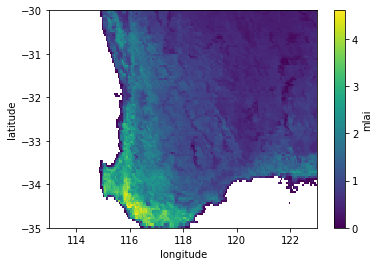

In [30]:
test1["mlai"].plot()

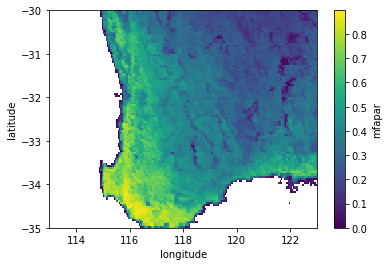

In [31]:
test1["mfapar"].plot()

In [32]:
test2 = xr.open_dataset("../data_processed/cfv00_calc_sa_Dec-1994_Feb-2000_djf_era5-mdp_wv10.nc")
test2

<xarray.Dataset>
Dimensions:    (hour: 24, latitude: 61, longitude: 141)
Coordinates:
  * longitude  (longitude) float32 -64.88 -64.62 -64.38 ... -30.38 -30.12 -29.88
  * latitude   (latitude) float32 -0.125 -0.375 -0.625 ... -14.62 -14.88 -15.12
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    u10        (hour, latitude, longitude) float32 ...
    v10        (hour, latitude, longitude) float32 ...

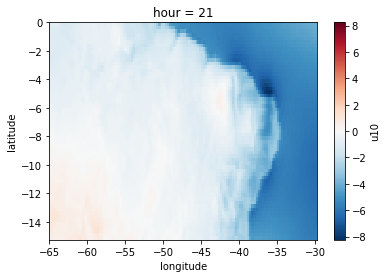

In [33]:
test2["u10"].sel(hour=21).plot()

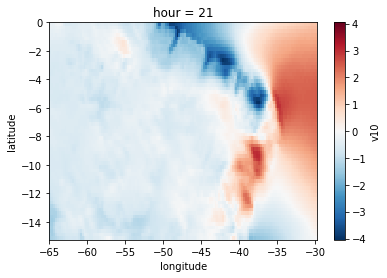

In [34]:
test2["v10"].sel(hour=21).plot()

In [35]:
test3 = xr.open_dataset("../data_processed/cfv00_diff_ca_Jan-1985_Dec-1994_Jan-1995_Jan-2004_all_era5-mdp_dnac.nc")
test3

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 41, hour: 24)
Coordinates:
  * longitude  (longitude) float32 -90.88 -90.62 -90.38 ... -81.38 -81.12 -80.88
  * latitude   (latitude) float32 16.88 16.62 16.38 16.12 ... 7.375 7.125 6.875
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    dnse       (hour, latitude, longitude) float32 ...
    dvidmf     (hour, latitude, longitude) float32 ...
    dvidcfwf   (hour, latitude, longitude) float32 ...
    dvidclwf   (hour, latitude, longitude) float32 ...
    dtcwv      (hour, latitude, longitude) float32 ...
    dnac       (hour, latitude, longitude) float32 ...

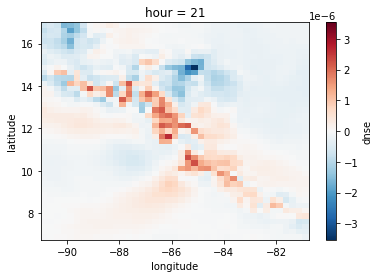

In [36]:
test3["dnse"].sel(hour=21).plot()

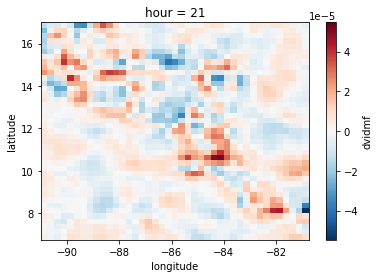

In [37]:
test3["dvidmf"].sel(hour=21).plot()

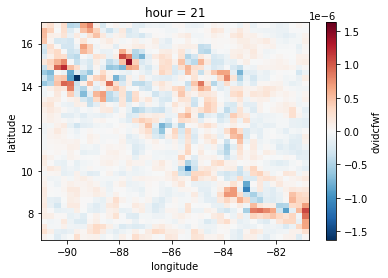

In [38]:
test3["dvidcfwf"].sel(hour=21).plot()

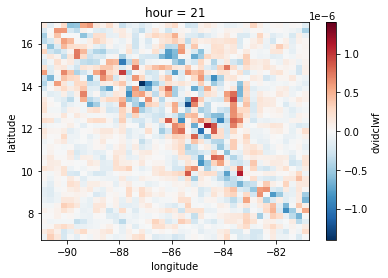

In [39]:
test3["dvidclwf"].sel(hour=21).plot()

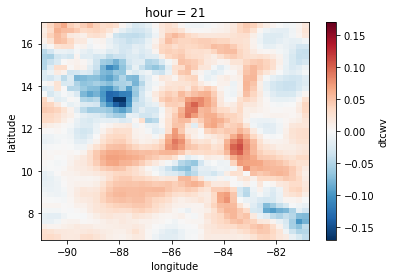

In [40]:
test3["dtcwv"].sel(hour=21).plot()

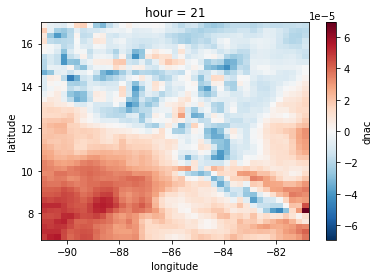

In [41]:
test3["dnac"].sel(hour=21).plot()

In [42]:
test4 = xr.open_dataset("../data_processed/cfv00_calc_sa_Dec-1994_Feb-2000_jja_era5-mdp_dwv100_stats.nc")
test4

<xarray.Dataset>
Dimensions:    (longitude: 141, latitude: 61)
Coordinates:
  * longitude  (longitude) float32 -64.88 -64.62 -64.38 ... -30.38 -30.12 -29.88
  * latitude   (latitude) float32 -0.125 -0.375 -0.625 ... -14.62 -14.88 -15.12
Data variables:
    hour_max   (latitude, longitude) int64 ...
    hour_min   (latitude, longitude) int64 ...
    max_u      (latitude, longitude) float32 ...
    max_v      (latitude, longitude) float32 ...
    min_u      (latitude, longitude) float32 ...
    min_v      (latitude, longitude) float32 ...
    mean_u     (latitude, longitude) float32 ...
    mean_v     (latitude, longitude) float32 ...
    range      (latitude, longitude) float32 ...

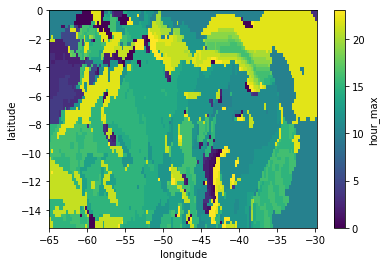

In [43]:
test4["hour_max"].plot()

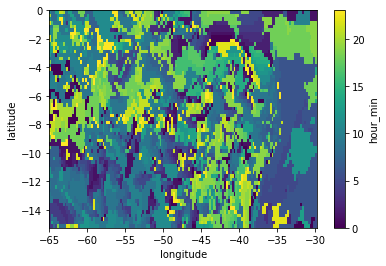

In [44]:
test4["hour_min"].plot()

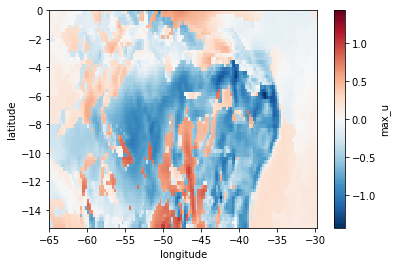

In [45]:
test4["max_u"].plot()

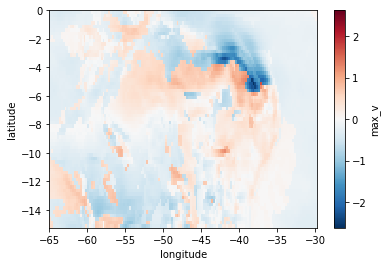

In [46]:
test4["max_v"].plot()

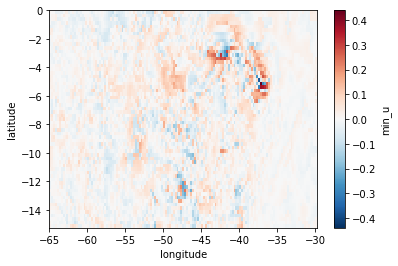

In [47]:
test4["min_u"].plot()

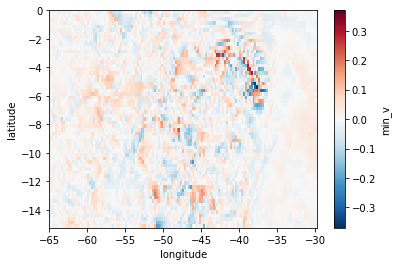

In [48]:
test4["min_v"].plot()

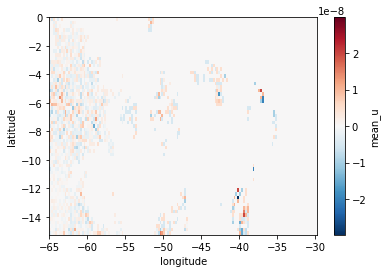

In [49]:
test4["mean_u"].plot()

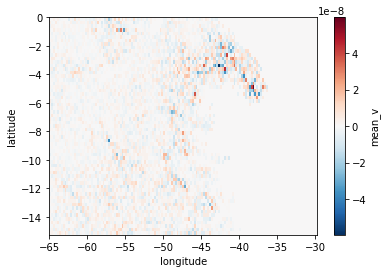

In [50]:
test4["mean_v"].plot()

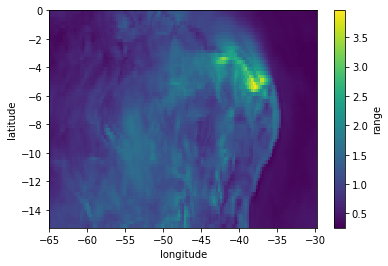

In [51]:
test4["range"].plot()

In [ ]:
test4["max"].plot()

In [ ]:
test4["min"].plot()

In [ ]:
test4["mean"].plot()

In [53]:
test5 = xr.open_dataset("../data_processed/cfv00_calc_wa_Jun-2000_Aug-2005_1-3-5-7-9-11_era5-wsd.nc")
test5

<xarray.Dataset>
Dimensions:     (longitude: 41, latitude: 21)
Coordinates:
  * longitude   (longitude) float32 113.1 113.4 113.6 ... 122.6 122.9 123.1
  * latitude    (latitude) float32 -30.12 -30.38 -30.62 ... -34.62 -34.88 -35.12
Data variables:
    ws10_mean   (latitude, longitude) float32 ...
    ws10_std    (latitude, longitude) float32 ...
    c10         (latitude, longitude) float32 ...
    k10         (latitude, longitude) float32 ...
    ws100_mean  (latitude, longitude) float32 ...
    ws100_std   (latitude, longitude) float32 ...
    c100        (latitude, longitude) float32 ...
    k100        (latitude, longitude) float32 ...
    eroe100     (latitude, longitude) float32 ...
    gcf100      (latitude, longitude) float64 ...

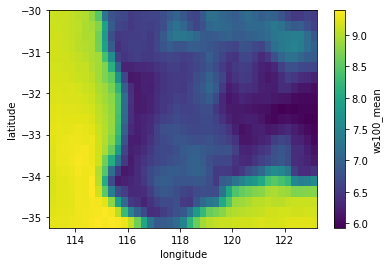

In [54]:
test5["ws100_mean"].plot()

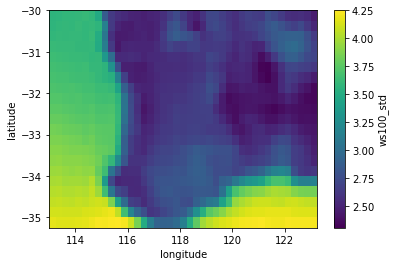

In [55]:
test5["ws100_std"].plot()

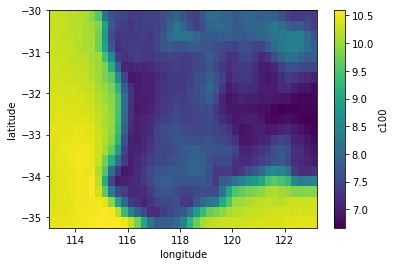

In [56]:
test5["c100"].plot()

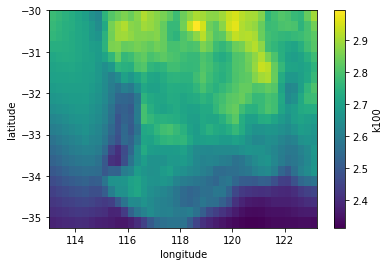

In [57]:
test5["k100"].plot()

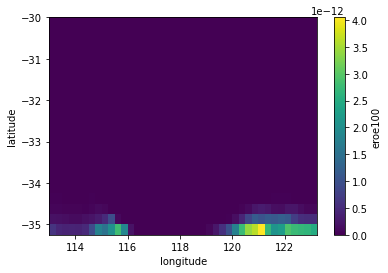

In [58]:
test5["eroe100"].plot()

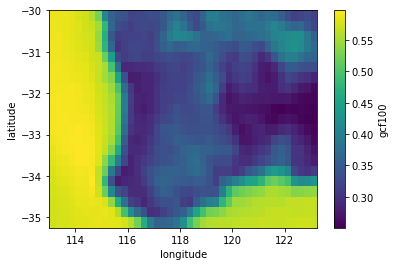

In [59]:
test5["gcf100"].plot()

In [60]:
test5["eroe100"].where(test5["eroe100"]==test5["eroe100"].max(), drop = True).squeeze()

<xarray.DataArray 'eroe100' ()>
array(4.050126e-12, dtype=float32)
Coordinates:
    longitude  float32 121.1
    latitude   float32 -35.12

In [63]:
%%time
calc_diff(calc_glass_mean_clim, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all")

CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1985_Dec-1990_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-2005_Dec-2010_all_glass-mean_modis.nc.
CREATED: file: ../data_processed/cfv00_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_glass-mean_mixed.nc.
CPU times: user 3min 9s, sys: 1min 3s, total: 4min 13s
Wall time: 3min 49s


In [62]:
%%time
calc_diff(calc_era5_mdp_clim_given_var_or_dvar, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all", "nac")

CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1985_Dec-1990_all_era5-mdp_nac.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1985_Dec-1990_all_era5-mdp_nac.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-2005_Dec-2010_all_era5-mdp_nac.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-2005_Dec-2010_all_era5-mdp_nac.nc.
CREATED: file: ../data_processed/cfv00_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-mdp_nac.nc.
CPU times: user 1.94 s, sys: 175 ms, total: 2.11 s
Wall time: 1.78 s


In [64]:
%%time
calc_diff(calc_era5_mdp_clim_stats_given_var_or_dvar, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all", "wv10")

CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/cfv00_calc_wa_Jan-1985_Dec-1990_all_era5-mdp_wv10.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/cfv00_calc_wa_Jan-1985_Dec-1990_all_era5-mdp_wv10.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1985_Dec-1990_all_era5-mdp_wv10_stats.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/cfv00_calc_wa_Jan-2005_Dec-2010_all_era5-mdp_wv10.nc.
CREATED: file for use in calc_era5_mdp_clim_stats_given_var_or_dvar: ../data_processed/cfv00_calc_wa_Jan-2005_Dec-2010_all_era5-mdp_wv10.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-2005_Dec-2010_all_era5-mdp_wv10_stats.nc.
CREATED: file: ../data_processed/cfv00_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-mdp_wv10_stats.nc.
CPU times: user 2.18 s, sys: 82.7 ms, total: 2.27 s
Wall time: 2.1 s


In [65]:
%%time
calc_diff(calc_era5_wsd_clim, "wa", "Jan-1985", "Dec-1990", "Jan-2005", "Dec-2010", "all")

CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1985_Dec-1990_all_era5-wsd.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-2005_Dec-2010_all_era5-wsd.nc.
CREATED: file: ../data_processed/cfv00_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-wsd.nc.
CPU times: user 12.6 s, sys: 6.25 s, total: 18.9 s
Wall time: 8.73 s


In [66]:
test6 = xr.open_dataset("../data_processed/cfv00_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_glass-mean_mixed.nc")
test6

<xarray.Dataset>
Dimensions:    (longitude: 200, latitude: 100)
Coordinates:
  * longitude  (longitude) float64 113.0 113.1 113.1 113.2 ... 122.9 122.9 123.0
  * latitude   (latitude) float64 -30.03 -30.08 -30.13 ... -34.88 -34.93 -34.98
Data variables:
    mlai       (latitude, longitude) float32 ...
    mfapar     (latitude, longitude) float32 ...

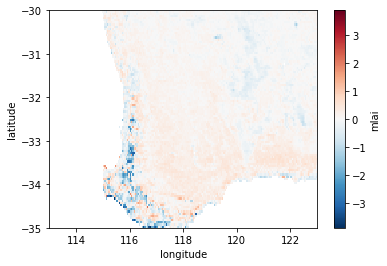

In [67]:
test6["mlai"].plot()

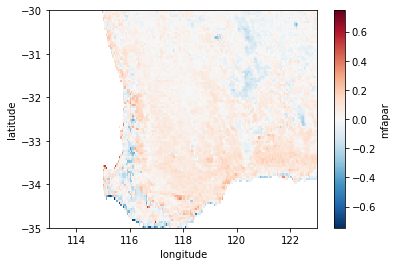

In [68]:
test6["mfapar"].plot()

In [69]:
test7 = xr.open_dataset("../data_processed/cfv00_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-mdp_nac.nc")
test7

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21, hour: 24)
Coordinates:
  * longitude  (longitude) float32 113.1 113.4 113.6 113.9 ... 122.6 122.9 123.1
  * latitude   (latitude) float32 -30.12 -30.38 -30.62 ... -34.62 -34.88 -35.12
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Data variables:
    nse        (hour, latitude, longitude) float32 ...
    vidmf      (hour, latitude, longitude) float32 ...
    vidcfwf    (hour, latitude, longitude) float32 ...
    vidclwf    (hour, latitude, longitude) float32 ...
    tcwv       (hour, latitude, longitude) float32 ...
    nac        (hour, latitude, longitude) float32 ...

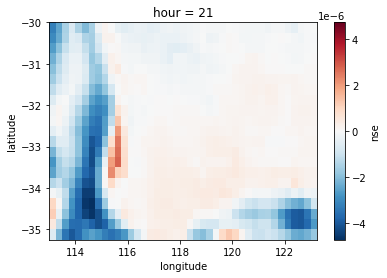

In [70]:
test7["nse"].sel(hour=21).plot()

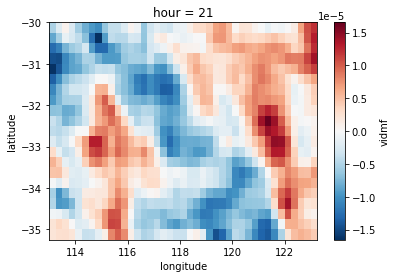

In [71]:
test7["vidmf"].sel(hour=21).plot()

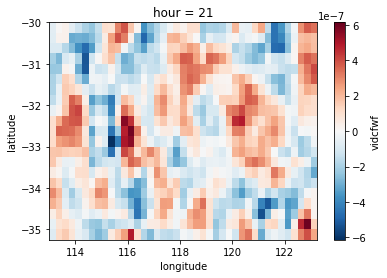

In [72]:
test7["vidcfwf"].sel(hour=21).plot()

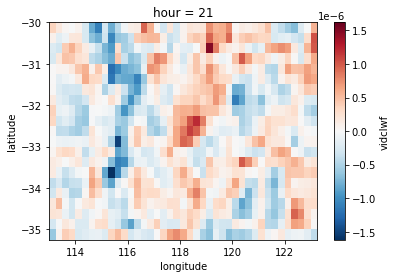

In [73]:
test7["vidclwf"].sel(hour=21).plot()

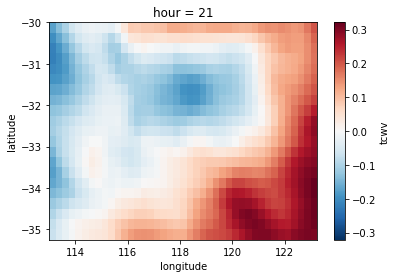

In [74]:
test7["tcwv"].sel(hour=21).plot()

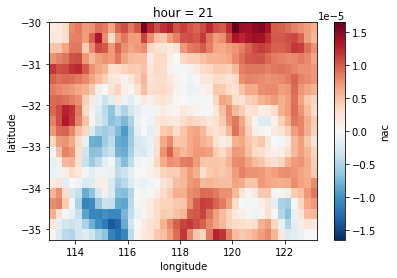

In [75]:
test7["nac"].sel(hour=21).plot()

In [76]:
test8 = xr.open_dataset("../data_processed/cfv00_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-mdp_wv10_stats.nc")
test8

<xarray.Dataset>
Dimensions:    (longitude: 41, latitude: 21)
Coordinates:
  * longitude  (longitude) float32 113.1 113.4 113.6 113.9 ... 122.6 122.9 123.1
  * latitude   (latitude) float32 -30.12 -30.38 -30.62 ... -34.62 -34.88 -35.12
Data variables:
    hour_max   (latitude, longitude) int64 ...
    hour_min   (latitude, longitude) int64 ...
    max_u      (latitude, longitude) float32 ...
    max_v      (latitude, longitude) float32 ...
    min_u      (latitude, longitude) float32 ...
    min_v      (latitude, longitude) float32 ...
    mean_u     (latitude, longitude) float32 ...
    mean_v     (latitude, longitude) float32 ...
    range      (latitude, longitude) float32 ...

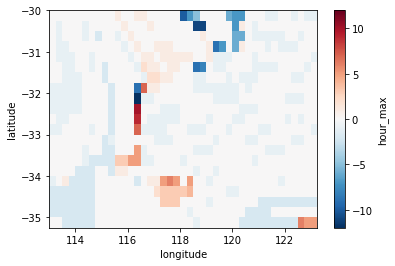

In [77]:
test8["hour_max"].plot()

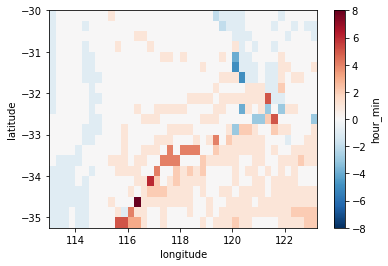

In [78]:
test8["hour_min"].plot()

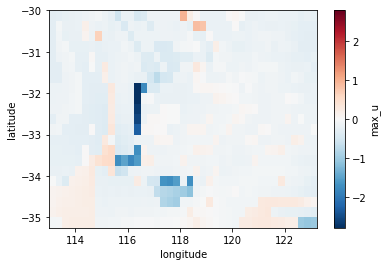

In [79]:
test8["max_u"].plot()

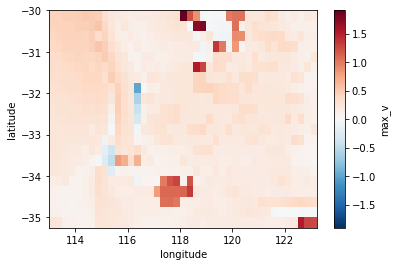

In [80]:
test8["max_v"].plot()

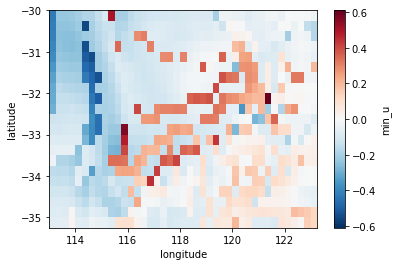

In [81]:
test8["min_u"].plot()

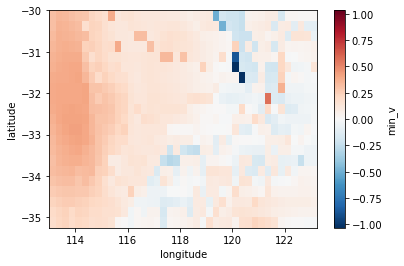

In [82]:
test8["min_v"].plot()

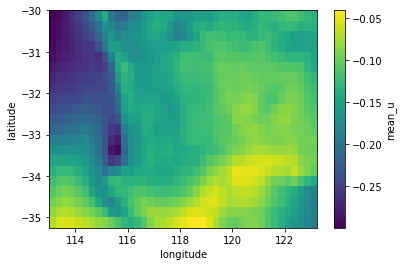

In [83]:
test8["mean_u"].plot()

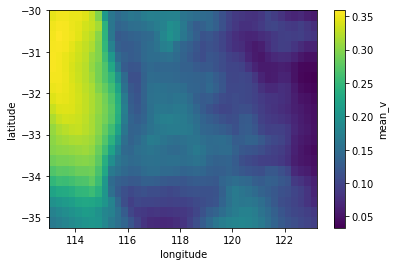

In [84]:
test8["mean_v"].plot()

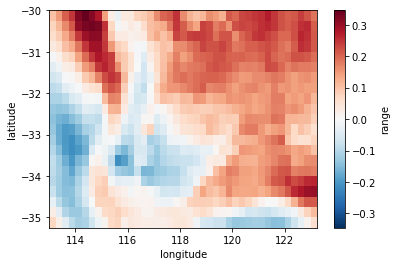

In [85]:
test8["range"].plot()

In [86]:
test9 = xr.open_dataset("../data_processed/cfv00_diff_wa_Jan-1985_Dec-1990_Jan-2005_Dec-2010_all_era5-wsd.nc")
test9

<xarray.Dataset>
Dimensions:     (longitude: 41, latitude: 21)
Coordinates:
  * longitude   (longitude) float32 113.1 113.4 113.6 ... 122.6 122.9 123.1
  * latitude    (latitude) float32 -30.12 -30.38 -30.62 ... -34.62 -34.88 -35.12
Data variables:
    ws10_mean   (latitude, longitude) float32 ...
    ws10_std    (latitude, longitude) float32 ...
    c10         (latitude, longitude) float32 ...
    k10         (latitude, longitude) float32 ...
    ws100_mean  (latitude, longitude) float32 ...
    ws100_std   (latitude, longitude) float32 ...
    c100        (latitude, longitude) float32 ...
    k100        (latitude, longitude) float32 ...
    eroe100     (latitude, longitude) float32 ...
    gcf100      (latitude, longitude) float64 ...

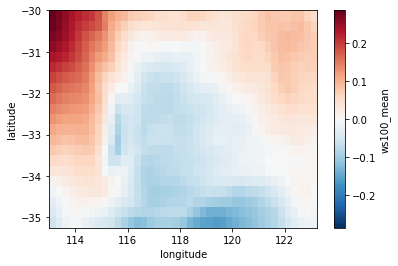

In [87]:
test9["ws100_mean"].plot()

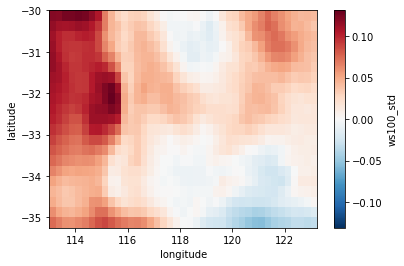

In [88]:
test9["ws100_std"].plot()

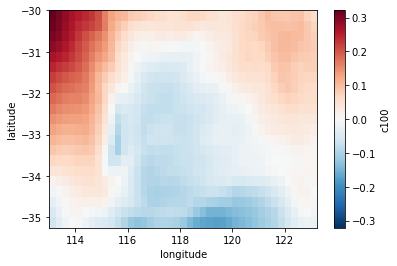

In [89]:
test9["c100"].plot()

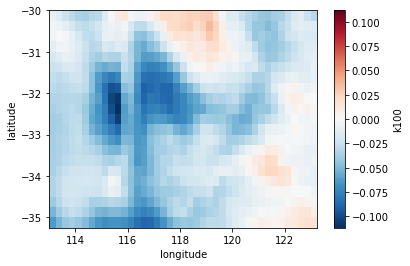

In [90]:
test9["k100"].plot()

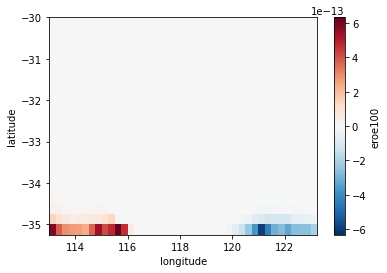

In [91]:
test9["eroe100"].plot()

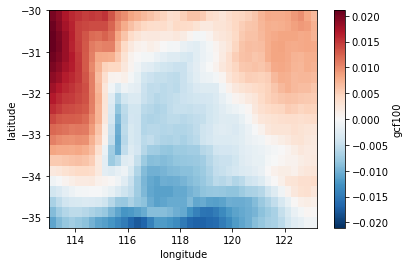

In [92]:
test9["gcf100"].plot()

In [93]:
test9["eroe100"].where(test9["eroe100"]==test9["eroe100"].max(), drop = True).squeeze()

<xarray.DataArray 'eroe100' ()>
array(6.3328547e-13, dtype=float32)
Coordinates:
    longitude  float32 115.6
    latitude   float32 -35.12

In [94]:
%%time
calc_era5_land_elev()

Opening: existing file for use in calc_era5_land_elev: ../data_raw/global_era5-slv_static/global_era5-slv_static_geopotential.nc.
Opening: existing file for use in calc_era5_land_elev: ../data_raw/global_era5-slv_static/global_era5-slv_static_land-sea-mask.nc.
CREATED: file: ../data_processed/cfv00_calc_global_static_land-elev.nc.
CPU times: user 77.1 ms, sys: 12.3 ms, total: 89.5 ms
Wall time: 91.2 ms


In [95]:
test10 = xr.open_dataset("../data_processed/cfv00_calc_global_static_land-elev.nc")
test10

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721)
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 89.88 89.62 89.38 ... -89.62 -89.88 -90.12
Data variables:
    lse        (latitude, longitude) float32 ...

In [96]:
%%time
calc_glass_rolling_avg_of_annual_diff("wa", 1984, 1987, 7)

CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1981_Dec-1981_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1982_Dec-1982_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_glass_rolling_avg_of_annual_diff: ../data_processed/cfv00_diff_wa_Jan-1981_Dec-1981_Jan-1982_Dec-1982_all_glass-mean_avhrr.nc.
Opening: existing file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1982_Dec-1982_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1983_Dec-1983_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_glass_rolling_avg_of_annual_diff: ../data_processed/cfv00_diff_wa_Jan-1982_Dec-1982_Jan-1983_Dec-1983_all_glass-mean_avhrr.nc.
Opening: existing file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1983_Dec-1983_all_glass-mean_avhrr.nc.
CREATED: file for use in calc_diff: ../data_processed/cfv00_calc_wa_Jan-1984_Dec-1984_all_glass-mean_avhrr.nc.
CR

In [97]:
test11 = xr.open_dataset("../data_processed/cfv00_calc_wa_1984_1987_7_glass-rolling-diff.nc")
test11

<xarray.Dataset>
Dimensions:    (year: 4, longitude: 200, latitude: 100)
Coordinates:
  * year       (year) int64 1984 1985 1986 1987
  * longitude  (longitude) float64 113.0 113.1 113.1 113.2 ... 122.9 122.9 123.0
  * latitude   (latitude) float64 -30.03 -30.08 -30.13 ... -34.88 -34.93 -34.98
Data variables:
    mlai       (year, latitude, longitude) float32 ...
    mfapar     (year, latitude, longitude) float32 ...

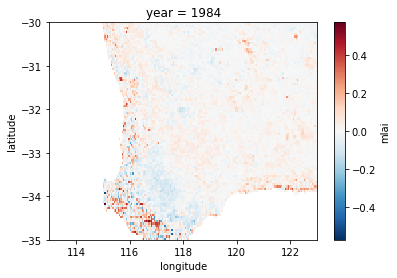

In [98]:
test11["mlai"].isel(year=0).plot()

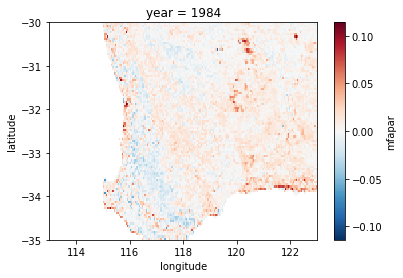

In [99]:
test11["mfapar"].isel(year=0).plot()